In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# importing libraries/modules, and functions
import pandas as pd
import numpy as np
import scipy.stats as stats

# visualization libraries
import matplotlib as mlp
# mlp.rcParams['figure.dpi'] = 300
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# created zillow library and functions
from acquire import get_zillow_dataset, clean_zillow_dataset, zillow_outliers, train_validate_test_split, select_kbest, recursive_feature_eng
from prepare import display_all

# sklearn library for data science
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

----
### ``Data Acquisition & Preparation:``

In [2]:
# initial query for MySQL zillow data
# query = '''
# SELECT *
#     FROM properties_2017
#         JOIN predictions_2017 USING (id)
#             JOIN propertylandusetype USING (propertylandusetypeid)
#                 WHERE transactiondate = 2017
#                     AND propertylandusedesc = "Single Family Residential"'''

In [3]:
# pulling the MySQL zillow data
# url = get_connection(user, password, host, "zillow")
# df = pd.read_sql(query, url)

In [4]:
# creating a csv file for storing
# df.to_csv("/Users/mijailmariano/codeup-data-science/regression-exercises/zillow_regression.csv")

In [5]:
# can now pull the zillow data using the following function:
zillow_df = get_zillow_dataset()
display_all(zillow_df.head()) # checks out!

,propertylandusetypeid,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,parcelid.1,logerror,transactiondate,propertylandusedesc
0,261.0,941,17223154,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,990.0,2088.0,2088.0,NaN,NaN,990.0,NaN,6111.0,1.0,2.0,2.0,445.0,NaN,NaN,34238617.0,-118813281.0,6692.0,NaN,NaN,NaN,NaN,NaN,1111,NaN,6.111008e+07,27110.0,2061.0,NaN,97118.0,8.0,NaN,1.0,NaN,NaN,484.0,NaN,1990.0,2.0,NaN,281174.0,562348.0,2016.0,281174.0,6405.58,NaN,NaN,6.111008e+13,14710129,-0.002189,2017-01-05,Single Family Residential
1,261.0,940,17223031,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,NaN,1376.0,2572.0,2572.0,NaN,NaN,1376.0,NaN,6111.0,2.0,3.0,2.0,620.0,NaN,NaN,34235499.0,-118808366.0,10360.0,NaN,NaN,NaN,NaN,NaN,1111,NaN,6.111008e+07,27110.0,2061.0,NaN,97118.0,8.0,NaN,NaN,NaN,NaN,474.0,NaN,1994.0,2.0,NaN,271103.0,444563.0,2016.0,173460.0,5151.84,NaN,NaN,6.111008e+13,12477465,0.053014,2017-01-05,Single Family Residential
2,261.0,939,17222931,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,66.0,1643.0,3213.0,3213.0,NaN,NaN,1643.0,NaN,6111.0,2.0,3.0,2.0,548.0,NaN,NaN,34243775.0,-118812925.0,11059.0,1.0,810.0,NaN,NaN,1.0,1111,NaN,6.111008e+07,27110.0,2061.0,NaN,97118.0,9.0,NaN,1.0,NaN,NaN,1534.0,NaN,1994.0,2.0,NaN,397886.0,613950.0,2016.0,216064.0,7042.40,NaN,NaN,6.111008e+13,14608599,0.010948,2017-01-05,Single Family Residential
3,261.0,937,17222339,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,2170.0,2170.0,2170.0,NaN,NaN,2170.0,NaN,6111.0,2.0,2.0,2.0,636.0,NaN,NaN,34244934.0,-118803182.0,10297.0,NaN,NaN,NaN,NaN,NaN,1111,NaN,6.111008e+07,27110.0,2061.0,NaN,97118.0,7.0,NaN,NaN,NaN,NaN,1002.0,NaN,1987.0,1.0,NaN,311147.0,622294.0,2016.0,311147.0,7143.40,NaN,NaN,6.111008e+13,12473718,0.053193,2017-01-05,Single Family Residential
4,261.0,935,17222139,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,874.0,1457.0,1457.0,NaN,NaN,874.0,NaN,6111.0,1.0,2.0,2.0,420.0,NaN,NaN,34247692.0,-118818283.0,8767.0,NaN,NaN,NaN,NaN,NaN,1111,NaN,6.111008e+07,27110.0,2061.0,NaN,97118.0,4.0,NaN,NaN,NaN,NaN,168.0,NaN,1986.0,2.0,NaN,270000.0,538000.0,2016.0,268000.0,6153.12,NaN,NaN,6.111008e+13,14603860,0.080817,2017-01-05,Single Family Residential


In [6]:
# exploring the dataset further
initial_shape = zillow_df.shape

In [7]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56079 entries, 0 to 56078
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         56079 non-null  float64
 1   id                            56079 non-null  int64  
 2   parcelid                      56079 non-null  int64  
 3   airconditioningtypeid         13650 non-null  float64
 4   architecturalstyletypeid      61 non-null     float64
 5   basementsqft                  43 non-null     float64
 6   bathroomcnt                   56079 non-null  float64
 7   bedroomcnt                    56079 non-null  float64
 8   buildingclasstypeid           0 non-null      float64
 9   buildingqualitytypeid         36990 non-null  float64
 10  calculatedbathnbr             55693 non-null  float64
 11  decktypeid                    360 non-null    float64
 12  finishedfloor1squarefeet      4757 non-null   float64
 13  c

In [8]:
# creating a function that bypasses pd row/cols limits
# with pd.option_context('display.max_rows', None):
#     display(zillow_df.isnull().sum())

display_all(zillow_df.isnull().sum())

propertylandusetypeid               0
id                                  0
parcelid                            0
airconditioningtypeid           42429
architecturalstyletypeid        56018
basementsqft                    56036
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             56079
buildingqualitytypeid           19089
calculatedbathnbr                 386
decktypeid                      55719
finishedfloor1squarefeet        51322
calculatedfinishedsquarefeet      231
finishedsquarefeet12              421
finishedsquarefeet13            56079
finishedsquarefeet15            56079
finishedsquarefeet50            51322
finishedsquarefeet6             55889
fips                                0
fireplacecnt                    48448
fullbathcnt                       386
garagecarcnt                    37832
garagetotalsqft                 37832
hashottuborspa                  54839
heatingorsystemtypeid           19004
latitude    

In [9]:
# checking total null percentage for ea. column
display_all(round(zillow_df.isnull().mean(), 3))

propertylandusetypeid           0.000
id                              0.000
parcelid                        0.000
airconditioningtypeid           0.757
architecturalstyletypeid        0.999
basementsqft                    0.999
bathroomcnt                     0.000
bedroomcnt                      0.000
buildingclasstypeid             1.000
buildingqualitytypeid           0.340
calculatedbathnbr               0.007
decktypeid                      0.994
finishedfloor1squarefeet        0.915
calculatedfinishedsquarefeet    0.004
finishedsquarefeet12            0.008
finishedsquarefeet13            1.000
finishedsquarefeet15            1.000
finishedsquarefeet50            0.915
finishedsquarefeet6             0.997
fips                            0.000
fireplacecnt                    0.864
fullbathcnt                     0.007
garagecarcnt                    0.675
garagetotalsqft                 0.675
hashottuborspa                  0.978
heatingorsystemtypeid           0.339
latitude    

In [10]:
# cleaning df for for feature with NULL % > 20% 
# though this may not be a necessary step at this time
# consider first, choosing features/variables from research/domain knowledge that may be closely tied to home value
# from these features/variables turn them into questions/hypothesis for exploration

dropped_cols = []
for col in zillow_df.columns:
    if zillow_df[col].isnull().mean() > 0.2:
        dropped_cols.append(col)
        zillow_df = zillow_df.drop(columns = col)

# returning initial shape vs. null drop shape
print(f'initial df shape: {initial_shape}')
print(f'shape after null drop: {zillow_df.shape}')
print('dropped columns:', *dropped_cols, sep = '\n- ')

initial df shape: (56079, 63)
shape after null drop: (56079, 30)
dropped columns:
- airconditioningtypeid
- architecturalstyletypeid
- basementsqft
- buildingclasstypeid
- buildingqualitytypeid
- decktypeid
- finishedfloor1squarefeet
- finishedsquarefeet13
- finishedsquarefeet15
- finishedsquarefeet50
- finishedsquarefeet6
- fireplacecnt
- garagecarcnt
- garagetotalsqft
- hashottuborspa
- heatingorsystemtypeid
- poolcnt
- poolsizesum
- pooltypeid10
- pooltypeid2
- pooltypeid7
- propertyzoningdesc
- regionidneighborhood
- storytypeid
- threequarterbathnbr
- typeconstructiontypeid
- unitcnt
- yardbuildingsqft17
- yardbuildingsqft26
- numberofstories
- fireplaceflag
- taxdelinquencyflag
- taxdelinquencyyear


In [11]:
# let's see all "id" columns that remain
# i presume that i will not need most, if not all of them - but let's check anyways

mask = zillow_df.columns.str.contains("id")
zillow_df.iloc[:, mask].columns

Index(['propertylandusetypeid', 'id', 'parcelid', 'regionidcity',
       'regionidcounty', 'regionidzip', 'parcelid.1'],
      dtype='object')

In [12]:
# will drop column "parcelid.1" from the mysql predictions_2017 table as this does not appear to have any significance to my current zillow dataframe
zillow_df[["parcelid", "parcelid.1"]] 

,parcelid,parcelid.1
0,17223154,14710129
1,17223031,12477465
2,17222931,14608599
3,17222339,12473718
4,17222139,14603860
...,...,...
56074,11040656,14445769
56075,11039751,12901433
56076,11038761,11087327
56077,11038661,10744723


In [13]:
zillow_df = zillow_df.drop(columns = "parcelid.1")

print(zillow_df.shape)
zillow_df.head()

(56079, 29)


,propertylandusetypeid,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,261.0,941,17223154,2.5,4.0,2.5,2088.0,2088.0,6111.0,2.0,...,1990.0,281174.0,562348.0,2016.0,281174.0,6405.58,6.111008e+13,-0.002189,2017-01-05,Single Family Residential
1,261.0,940,17223031,3.0,4.0,3.0,2572.0,2572.0,6111.0,3.0,...,1994.0,271103.0,444563.0,2016.0,173460.0,5151.84,6.111008e+13,0.053014,2017-01-05,Single Family Residential
2,261.0,939,17222931,3.5,4.0,3.5,3213.0,3213.0,6111.0,3.0,...,1994.0,397886.0,613950.0,2016.0,216064.0,7042.40,6.111008e+13,0.010948,2017-01-05,Single Family Residential
3,261.0,937,17222339,2.0,3.0,2.0,2170.0,2170.0,6111.0,2.0,...,1987.0,311147.0,622294.0,2016.0,311147.0,7143.40,6.111008e+13,0.053193,2017-01-05,Single Family Residential
4,261.0,935,17222139,2.0,2.0,2.0,1457.0,1457.0,6111.0,2.0,...,1986.0,270000.0,538000.0,2016.0,268000.0,6153.12,6.111008e+13,0.080817,2017-01-05,Single Family Residential


In [14]:
# remaining columns/features include:
pd.Series(zillow_df.columns.sort_values())

0                   assessmentyear
1                      bathroomcnt
2                       bedroomcnt
3                calculatedbathnbr
4     calculatedfinishedsquarefeet
5              censustractandblock
6             finishedsquarefeet12
7                             fips
8                      fullbathcnt
9                               id
10           landtaxvaluedollarcnt
11                        latitude
12                        logerror
13                       longitude
14               lotsizesquarefeet
15                        parcelid
16       propertycountylandusecode
17             propertylandusedesc
18           propertylandusetypeid
19          rawcensustractandblock
20                    regionidcity
21                  regionidcounty
22                     regionidzip
23                         roomcnt
24      structuretaxvaluedollarcnt
25                       taxamount
26               taxvaluedollarcnt
27                 transactiondate
28                  

----
### <u>**``Initial Questions for Exploration:``**</u>

**``Target Variable:``**
* Tax_Value_Dollar_Count

``Features That May* Lead to Data Leakage:``
- land tax value dollar count
- structure tax value dollar count
- tax amount
- land tax value dollar count
- structure tax value dollar count


**1. Does the home location matter? (must try) model per county**

I presume location matters in determining the final value/price of a home, as there could be economic factors (e.g., cost-of-living/inflationary considerations). Additionally, homes typically closer to metropolitan or labor creating areas (employment) may be more costly to live-in than more rural/less-labor promoted areas.

* Homes closer to schools (positive)
* Home closer to parks/recreational areas (positive)
* Homes near hospitals/hospice care (positive)
* Areas with “less” crime rates or law-enforcement? (positive)
* Areas near bodies of water may be less attractive? Given the additional insurance costs/natural disaster considerations (negative)

``Features:``
1. Fips
2. Latitude 
3. Longitude 
4. Parcel_id
5. Region_City_id
6. Region_id_County
7. Region_id_Zip


**2. Does the size of the home matter?**

I presume that the larger the home (as measured by sq. ft.), the higher the home value will be. A larger home can be more attractive to home buyers since the space can act as both an initial family home, but also a “forever home”. Meaning that people who might not initially have a use for the additional space - may see the potential benefits of having it when they are ready to either 1. Expand their family/or use of the space or 2. View the space as a future investment for someone willing to pay the same or more for this space (investment thinking). 

* Consider the total number of baths 
* Consider the total number of rooms

``Features:``
1. Bathroom_Count
2. Bedroom_Count
3. Calculated_Finished_Sq_Feet
4. Full_Bath_Count

**3. Does the period of when a home is purchased matter?**

I presume that when* a home is placed on the market/is purchased matters. Home buyers may be more reluctant to purchase a home in the colder regional months (e.g., typically winter) when the weather may be less favorable for moving. There may also be *renter factors or periods in the year when leases end and renters make the decision to purchase a home, subsequently driving more buyers to the market and thus potentially increasing home values. 

*(higher demand + “same” or not enough supply = more competition/higher home purchase price)*

* Consider seasonal patterns (e.g., summer months vs. winter) 

``Features:``
1. Assessment_Year
2. Year_built
3. Transaction_Date


**<u>Features not taken forward after initial query pull:</u>**

- **parcel_id** 
  - Though may be needed in final predictions/report
<br> </br>

- **room_count** 
  - This is the total number of rooms in a home. Omitting this since it may be too closely associated to other features such as bathrooms and bedrooms. Additionally, this analysis presumes that all homes have standard rooms such as kitchens and living-rooms.
<br> </br>
- calculated bath and bedroom
- full bath count
- census tract and block
- finished squared feet 12
- property county land use code
- raw census tract and block
- assessment tax year
- land tax value dollar count
- structure tax value dollar count
- tax amount
- structure tax value dollar count
- assessment tax year



-----

In [15]:
exploration_cols = [
'taxvaluedollarcnt',
'bathroomcnt',
'bedroomcnt',
'calculatedfinishedsquarefeet',
'fips',
'latitude',
'longitude',
'lotsizesquarefeet',
'regionidcity',
'regionidcounty',
'regionidzip',
'yearbuilt',
'transactiondate'
]

In [16]:
# creating new dataframe for exploration:

df = zillow_df[exploration_cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56079 entries, 0 to 56078
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   taxvaluedollarcnt             56071 non-null  float64
 1   bathroomcnt                   56079 non-null  float64
 2   bedroomcnt                    56079 non-null  float64
 3   calculatedfinishedsquarefeet  55848 non-null  float64
 4   fips                          56079 non-null  float64
 5   latitude                      56079 non-null  float64
 6   longitude                     56079 non-null  float64
 7   lotsizesquarefeet             55729 non-null  float64
 8   regionidcity                  55025 non-null  float64
 9   regionidcounty                56079 non-null  float64
 10  regionidzip                   55979 non-null  float64
 11  yearbuilt                     55830 non-null  float64
 12  transactiondate               56079 non-null  object 
dtypes

In [17]:
# let's rename columns for clarity

df = df.rename(columns = {
'taxvaluedollarcnt': "home_value",
'bathroomcnt': "bathroom_count",
'bedroomcnt': "bedroom_count",
'calculatedfinishedsquarefeet': "living_sq_feet",
'fips': "fips_code",
'lotsizesquarefeet': "property_sq_feet",
'parcelid': "property_id",
'regionidcity': "city_id",
'regionidcounty': "county_id",
'regionidzip': "zip_code",
'transactiondate': "purchase_date",
'yearbuilt': "year_built",
})
df.columns.to_list() # checks out!

['home_value',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'fips_code',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'county_id',
 'zip_code',
 'year_built',
 'purchase_date']

In [18]:
# let's confirm the df shape:
initial_shape = df.shape
initial_shape

(56079, 13)

In [19]:
# let's recheck the number of null values in columns/features:
df.isnull().sum()

home_value             8
bathroom_count         0
bedroom_count          0
living_sq_feet       231
fips_code              0
latitude               0
longitude              0
property_sq_feet     350
city_id             1054
county_id              0
zip_code             100
year_built           249
purchase_date          0
dtype: int64

In [20]:
# let's check the null percentage per feature/column:
df.isnull().mean()

home_value          0.000143
bathroom_count      0.000000
bedroom_count       0.000000
living_sq_feet      0.004119
fips_code           0.000000
latitude            0.000000
longitude           0.000000
property_sq_feet    0.006241
city_id             0.018795
county_id           0.000000
zip_code            0.001783
year_built          0.004440
purchase_date       0.000000
dtype: float64

In [21]:
(df.isnull().mean() * 100).round(3)

home_value          0.014
bathroom_count      0.000
bedroom_count       0.000
living_sq_feet      0.412
fips_code           0.000
latitude            0.000
longitude           0.000
property_sq_feet    0.624
city_id             1.879
county_id           0.000
zip_code            0.178
year_built          0.444
purchase_date       0.000
dtype: float64

**<u>``Notes on remaining null values:``</u>**

1. since it is not know how this data was collected, it is therfore difficult to properly determine the cause of missing information (MCAR/MAR/MNAR)
2. area specific information/values would be relatively difficult here to predict and given the relatively low percentage of null values - i dont believe at this current stage it is beneficial to handle these values in a meaningful way that would generate any additional insight into this analysis
3. most features at this stage are comprised of <2% of null values - therefore, i will drop these and note which features contained nulls:


|feature| null % |
|----|----|
|'home_value'|0.014|
|'living_sq_feet'|0.41|
|'property_sq_feet'|0.62|
|'city_id'|1.88|
|'zip_code'|0.18|
|'year_built'|0.44|

------

In [22]:
# dropping nulls and rechecking df shape:
df = df.dropna()
shape_after_nulls = df.shape
shape_after_nulls

(54553, 13)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54553 entries, 0 to 56078
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   home_value        54553 non-null  float64
 1   bathroom_count    54553 non-null  float64
 2   bedroom_count     54553 non-null  float64
 3   living_sq_feet    54553 non-null  float64
 4   fips_code         54553 non-null  float64
 5   latitude          54553 non-null  float64
 6   longitude         54553 non-null  float64
 7   property_sq_feet  54553 non-null  float64
 8   city_id           54553 non-null  float64
 9   county_id         54553 non-null  float64
 10  zip_code          54553 non-null  float64
 11  year_built        54553 non-null  float64
 12  purchase_date     54553 non-null  object 
dtypes: float64(12), object(1)
memory usage: 5.8+ MB


In [24]:
# let's check the total number of unique values/feature options per column:

for col in df.columns:
    print(f'Column/Feature:  {col}'),
    print(f'Feature/value Type:  {df[col].dtype}'),
    print(f'Feature min:  {df[col].min()} | Feature max:  {df[col].max()}'),
    print(df[col].unique()),
    print("-----------------------------------------------"),
    print()

Column/Feature:  home_value
Feature/value Type:  float64
Feature min:  9.0 | Feature max:  30166843.0
[562348. 444563. 613950. ... 165419. 419009. 277029.]
-----------------------------------------------

Column/Feature:  bathroom_count
Feature/value Type:  float64
Feature min:  0.0 | Feature max:  20.0
[ 2.5  3.   3.5  2.   1.   1.5  4.5  4.   0.   5.   5.5  6.   8.   7.
 10.   7.5 11.   9.   8.5  6.5 13.   9.5 20.  19.5]
-----------------------------------------------

Column/Feature:  bedroom_count
Feature/value Type:  float64
Feature min:  0.0 | Feature max:  25.0
[ 4.  3.  2.  5.  6.  1.  0.  8.  7.  9. 25. 10. 11.]
-----------------------------------------------

Column/Feature:  living_sq_feet
Feature/value Type:  float64
Feature min:  20.0 | Feature max:  26345.0
[2088. 2572. 3213. ... 4466. 3620. 7182.]
-----------------------------------------------

Column/Feature:  fips_code
Feature/value Type:  float64
Feature min:  6037.0 | Feature max:  6111.0
[6111. 6059. 6037.]
-------

In [25]:
col_lst = df.columns.to_list()
col_lst

['home_value',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'fips_code',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'county_id',
 'zip_code',
 'year_built',
 'purchase_date']

In [26]:
# converting the following feature to "int" type
# add to function::: 

to_interger = ["bedroom_count", "city_id", "county_id", "zip_code"]
df[to_interger] = df[to_interger].astype("int")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54553 entries, 0 to 56078
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   home_value        54553 non-null  float64
 1   bathroom_count    54553 non-null  float64
 2   bedroom_count     54553 non-null  int64  
 3   living_sq_feet    54553 non-null  float64
 4   fips_code         54553 non-null  float64
 5   latitude          54553 non-null  float64
 6   longitude         54553 non-null  float64
 7   property_sq_feet  54553 non-null  float64
 8   city_id           54553 non-null  int64  
 9   county_id         54553 non-null  int64  
 10  zip_code          54553 non-null  int64  
 11  year_built        54553 non-null  float64
 12  purchase_date     54553 non-null  object 
dtypes: float64(8), int64(4), object(1)
memory usage: 5.8+ MB


In [27]:
# summary stats:

summary_stats = df.describe().T
summary_stats["range"] = summary_stats["max"] - summary_stats["min"]
summary_stats.round()

,count,mean,std,min,25%,50%,75%,max,range
home_value,54553.0,452590.0,589245.0,9.0,186629.0,327120.0,528847.0,30166843.0,30166834.0
bathroom_count,54553.0,2.0,1.0,0.0,2.0,2.0,3.0,20.0,20.0
bedroom_count,54553.0,3.0,1.0,0.0,3.0,3.0,4.0,25.0,25.0
living_sq_feet,54553.0,1858.0,955.0,20.0,1260.0,1624.0,2200.0,26345.0,26325.0
fips_code,54553.0,6049.0,21.0,6037.0,6037.0,6037.0,6059.0,6111.0,74.0
latitude,54553.0,34014958.0,246771.0,33340711.0,33837675.0,34016847.0,34179492.0,34806946.0,1466235.0
longitude,54553.0,-118207144.0,351957.0,-119448392.0,-118401375.0,-118160045.0,-117950149.0,-117571939.0,1876453.0
property_sq_feet,54553.0,11231.0,91414.0,169.0,5686.0,6790.0,8600.0,6971010.0,6970841.0
city_id,54553.0,35503.0,54205.0,3491.0,12447.0,24832.0,44116.0,396556.0,393065.0
county_id,54553.0,2561.0,787.0,1286.0,2061.0,3101.0,3101.0,3101.0,1815.0


----
### <u>``Univariate Feature Analysis:``</u>

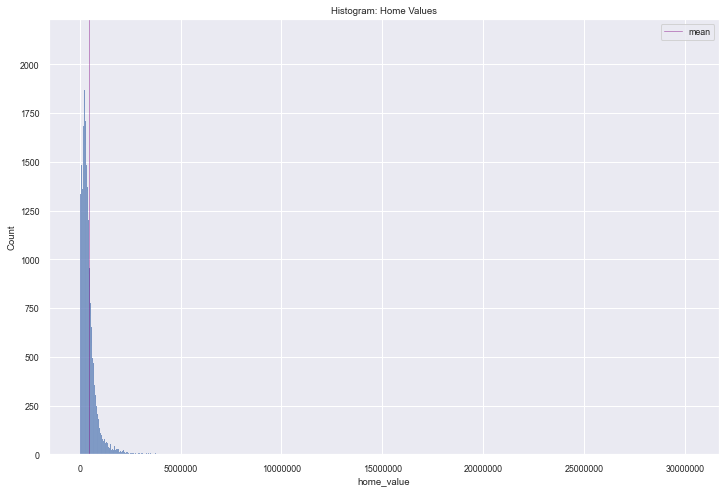

In [28]:
# beginning with the target variable:

plt.figure(figsize = (12, 8))
sns.set(font_scale = .8)
ax = sns.histplot(df["home_value"])

# removing axes scientific notation 
ax.ticklabel_format(style = "plain")

plt.axvline(df["home_value"].mean(), linewidth = 1, color = 'purple', alpha = 0.4, label = "mean")
plt.legend()
plt.title("Histogram: Home Values")
plt.show()

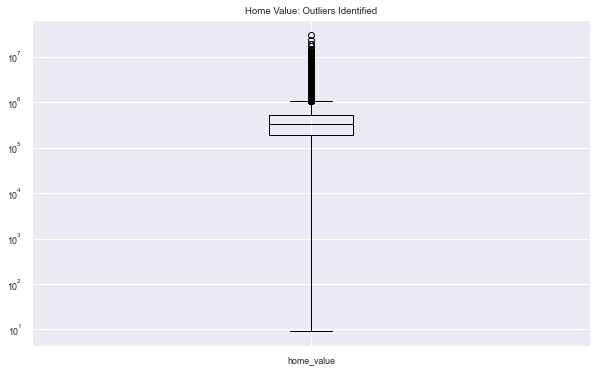

In [29]:
# box plot where outliers are present
plt.figure(figsize = (10, 6))
df.boxplot(column = "home_value", color = "black")

plt.semilogy()
plt.title("Home Value: Outliers Identified")
plt.show()

In [30]:
# mansion style homes 
# where living sq footage > 8K sq ft.
# 90th percent quartile for homes under this criteria = ~900K

over_8k = (df[df["living_sq_feet"] <= 8_000].home_value)
np.quantile(over_8k, q = [.90])

array([833830.4])

In [31]:
# percentage of homes in the dataset that are >= 1.5MIL 
# cleaning dataset for values over 1.5mil as these homes may be considered to be 

print(f'Total Num. of homes that are equal to or greater than 900K in value: {(df["home_value"] >= 900_000).sum()}')
print("---------")
print(f'Total Num. of homes that have 8K or greater living sq. footage: {(df["living_sq_feet"] >= 8_000).sum()}')
print("---------")
print(f'Total Num. of homes that have eight (8) or greater bedrooms: {(df["bedroom_count"] >= 8).sum()}')
print(f'Total Num. of homes that have 6 or greater bedrooms: {(df["bedroom_count"] >= 6).sum()}')
print(f'Total Num. of homes that have 0 bedrooms: {(df["bedroom_count"] == 0).sum()}')
print("---------")
print(f'Total Num. of homes that have 6.5 or greater baths: {(df["bathroom_count"] >= 6.5).sum()}')
print(f'Total Num. of homes that have eight (8) or greater baths: {(df["bathroom_count"] >= 8).sum()}')
print(f'Total Num. of homes that have 0 baths: {(df["bathroom_count"] == 0).sum()}')
print("----------------------------------")
print(f'Percentage of homes that are equal to or greater than 900K in value: {(df["home_value"] >= 900_000).mean().round(3)}')
print(f'Percentage of homes that have 8K or greater living sq. footage: {(df["living_sq_feet"] >= 8_000).mean().round(3)}')
print(f'Percentage of homes that have greater than 6 bedrooms: {(df["bedroom_count"] > 6).mean().round(3)}')
print(f'Percentage of homes that have greater than 6.5 bathrooms: {(df["bathroom_count"] > 6.5).mean().round(3)}')

Total Num. of homes that are equal to or greater than 900K in value: 4752
---------
Total Num. of homes that have 8K or greater living sq. footage: 104
---------
Total Num. of homes that have eight (8) or greater bedrooms: 42
Total Num. of homes that have 6 or greater bedrooms: 769
Total Num. of homes that have 0 bedrooms: 121
---------
Total Num. of homes that have 6.5 or greater baths: 225
Total Num. of homes that have eight (8) or greater baths: 81
Total Num. of homes that have 0 baths: 130
----------------------------------
Percentage of homes that are equal to or greater than 900K in value: 0.087
Percentage of homes that have 8K or greater living sq. footage: 0.002
Percentage of homes that have greater than 6 bedrooms: 0.003
Percentage of homes that have greater than 6.5 bathrooms: 0.004


In [32]:
# dropping identified outlier cutoffs in the dataset 
# as these homes may represent houses larger than the majority homes, therefore making the analysis or future prediction less accurate when comparing these outliers.

df = df[df["home_value"] <= 900_000]
df = df[df["living_sq_feet"] <= 8_000]

# also removing homes with 0 bedrooms as this appears to be slightly "irregular"
df = df[(df["bedroom_count"] > 0) & (df["bedroom_count"] <= 6)]

# also removing homes with 0 bathrooms as this appears to be slightly "irregular"
df = df[(df["bathroom_count"] > 0) & (df["bathroom_count"] <= 6.5)]

shape_after_outliers = df.shape
shape_after_outliers

(49582, 13)

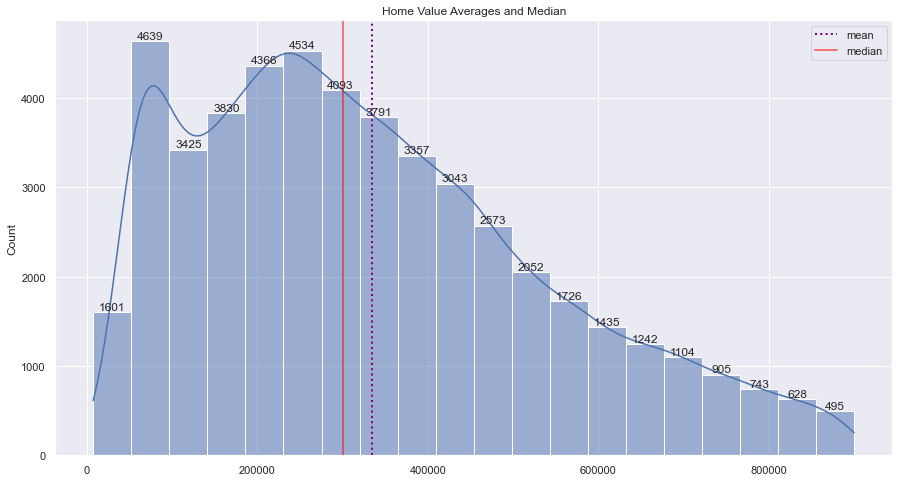

In [33]:
# let's check target again
from acquire import plot_target, plot_continuous, plot_discrete

plot_target(df["home_value"])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 56078
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   home_value        49582 non-null  float64
 1   bathroom_count    49582 non-null  float64
 2   bedroom_count     49582 non-null  int64  
 3   living_sq_feet    49582 non-null  float64
 4   fips_code         49582 non-null  float64
 5   latitude          49582 non-null  float64
 6   longitude         49582 non-null  float64
 7   property_sq_feet  49582 non-null  float64
 8   city_id           49582 non-null  int64  
 9   county_id         49582 non-null  int64  
 10  zip_code          49582 non-null  int64  
 11  year_built        49582 non-null  float64
 12  purchase_date     49582 non-null  object 
dtypes: float64(8), int64(4), object(1)
memory usage: 5.3+ MB


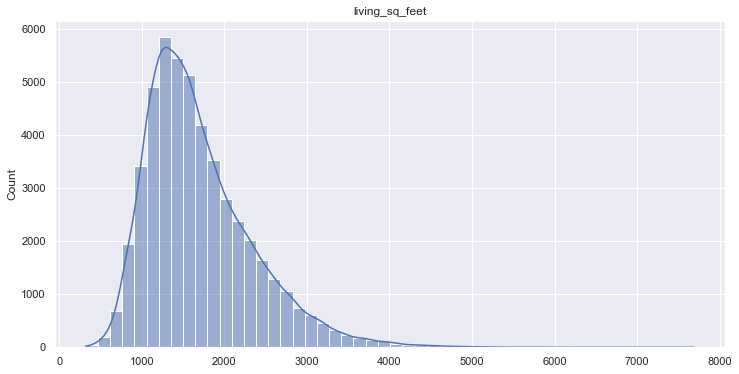

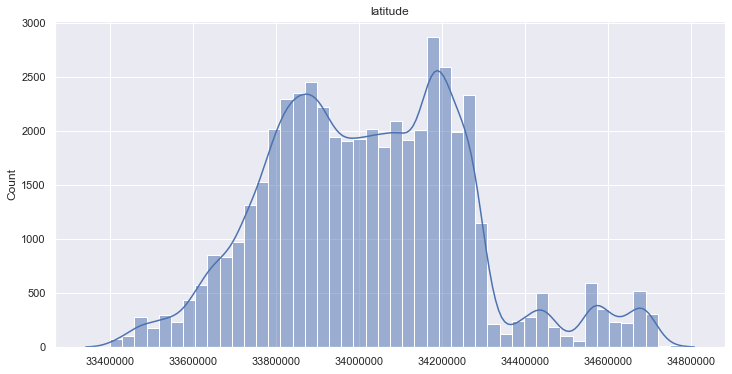

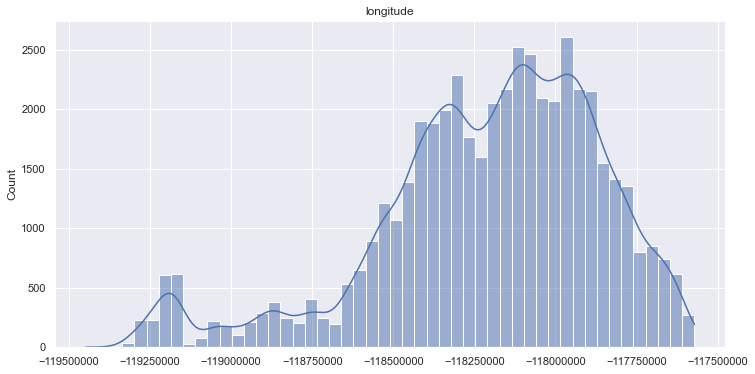

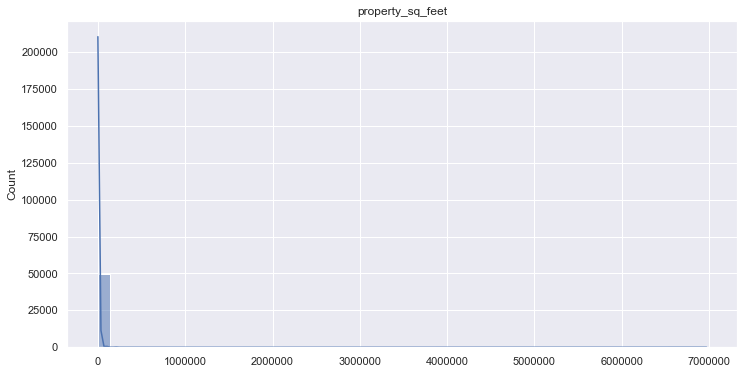

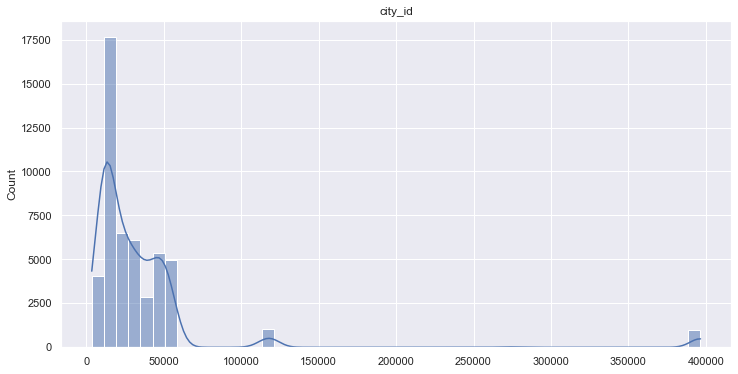

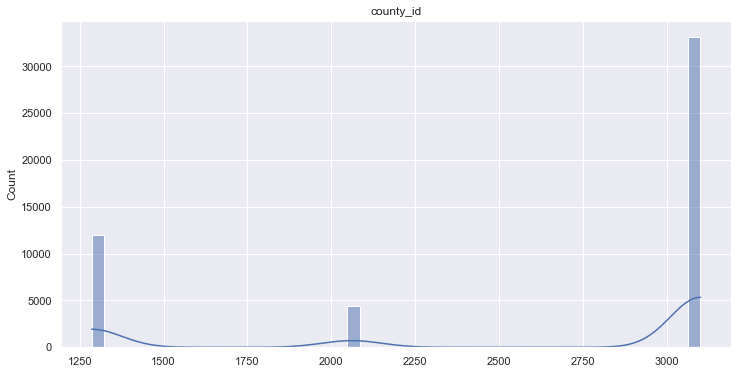

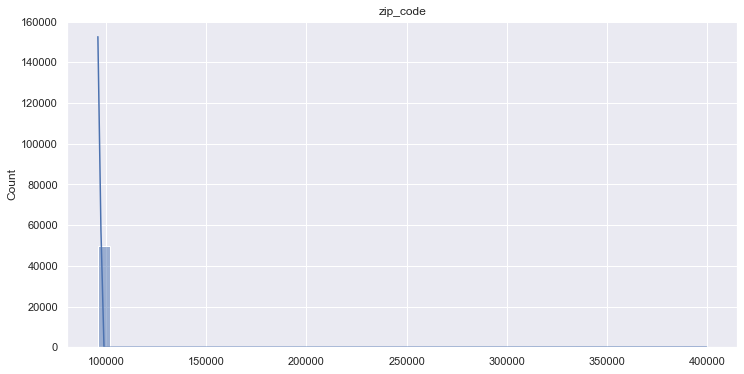

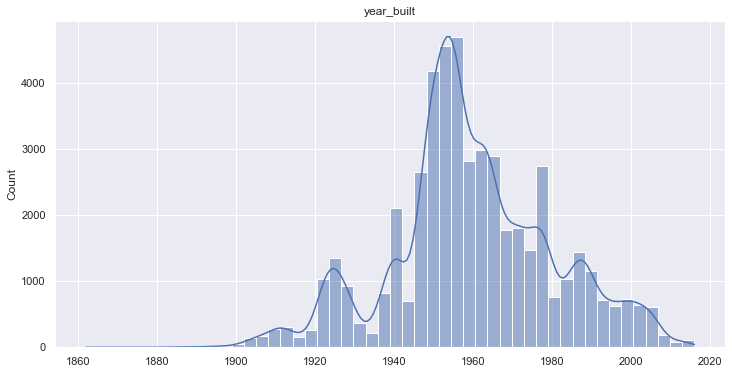

In [35]:
# setting and plotting continuous features/variables

continuous_vars = [
 'living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'county_id',
 'zip_code',
 'year_built'
]

plot_continuous(df)

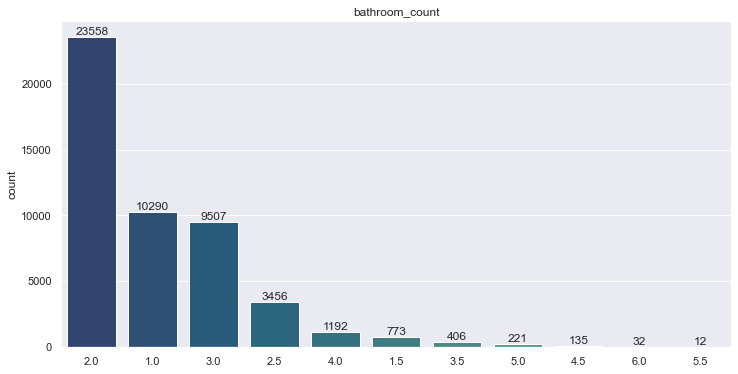

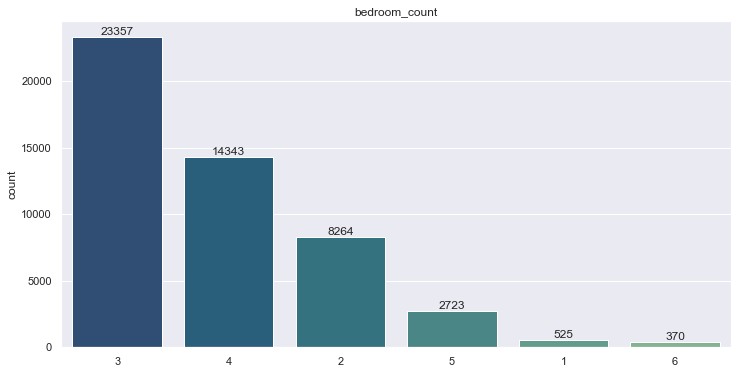

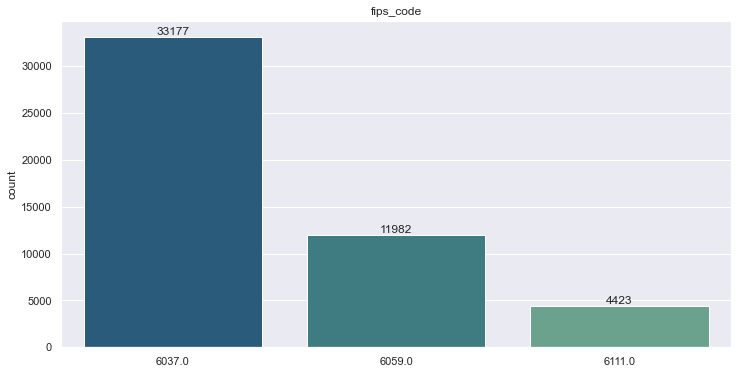

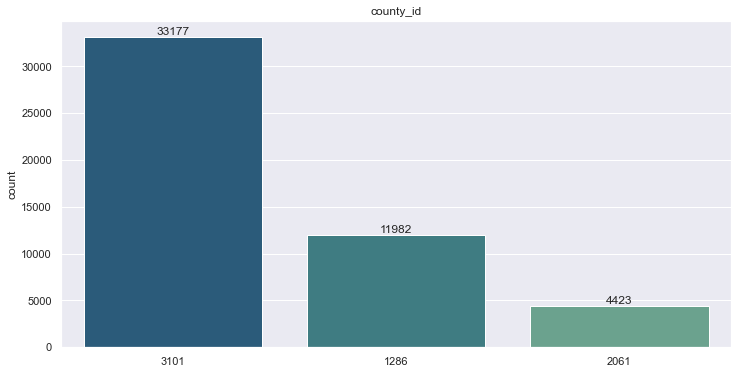

In [36]:
# plotting categorical/potential discrete features/columns:

discrete_vars = [
    'bathroom_count',
    'bedroom_count',
    'fips_code'
    ]

plot_discrete(df)

In [37]:
# converting purchase date/transaction date to datetime type
# function::::

df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 56078
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   home_value        49582 non-null  float64       
 1   bathroom_count    49582 non-null  float64       
 2   bedroom_count     49582 non-null  int64         
 3   living_sq_feet    49582 non-null  float64       
 4   fips_code         49582 non-null  float64       
 5   latitude          49582 non-null  float64       
 6   longitude         49582 non-null  float64       
 7   property_sq_feet  49582 non-null  float64       
 8   city_id           49582 non-null  int64         
 9   county_id         49582 non-null  int64         
 10  zip_code          49582 non-null  int64         
 11  year_built        49582 non-null  float64       
 12  purchase_date     49582 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(4)
memory usage: 5.3 MB


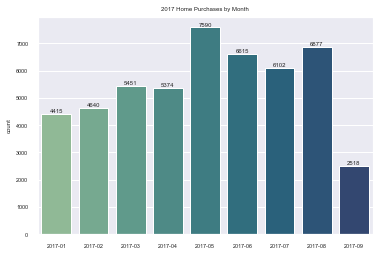

In [38]:
# let's plot the purchase/transaction dates
# creating a new column/home purchase by 2017 month
# add function:::::

# creating a lambda function to isolate the dates by month and year
months_lst = df['purchase_date'].map(lambda dt: dt.strftime('%Y-%m'))

# adding the new 2017 month series to main df as new column
df["purchase_month"] = months_lst.astype("str")

grouped_df = df.sort_values("purchase_month").groupby('purchase_month').size().to_frame("count").reset_index()

sns.set(font_scale = .5, style = "darkgrid")
ax = sns.countplot(x = "purchase_month",
                data = df,
                order = grouped_df["purchase_month"],
                palette = "crest")

ax.bar_label(ax.containers[0])

plt.xlabel(None)
plt.title("2017 Home Purchases by Month")
plt.show()

In [39]:
df.head()

,home_value,bathroom_count,bedroom_count,living_sq_feet,fips_code,latitude,longitude,property_sq_feet,city_id,county_id,zip_code,year_built,purchase_date,purchase_month
0,562348.0,2.5,4,2088.0,6111.0,34238617.0,-118813281.0,6692.0,27110,2061,97118,1990.0,2017-01-05,2017-01
1,444563.0,3.0,4,2572.0,6111.0,34235499.0,-118808366.0,10360.0,27110,2061,97118,1994.0,2017-01-05,2017-01
2,613950.0,3.5,4,3213.0,6111.0,34243775.0,-118812925.0,11059.0,27110,2061,97118,1994.0,2017-01-05,2017-01
3,622294.0,2.0,3,2170.0,6111.0,34244934.0,-118803182.0,10297.0,27110,2061,97118,1987.0,2017-01-05,2017-01
4,538000.0,2.0,2,1457.0,6111.0,34247692.0,-118818283.0,8767.0,27110,2061,97118,1986.0,2017-01-05,2017-01


----
**``establishing categorical/continuous variables/features``**

In [40]:
df.columns.tolist()

['home_value',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'fips_code',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'county_id',
 'zip_code',
 'year_built',
 'purchase_date',
 'purchase_month']

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 56078
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   home_value        49582 non-null  float64       
 1   bathroom_count    49582 non-null  float64       
 2   bedroom_count     49582 non-null  int64         
 3   living_sq_feet    49582 non-null  float64       
 4   fips_code         49582 non-null  float64       
 5   latitude          49582 non-null  float64       
 6   longitude         49582 non-null  float64       
 7   property_sq_feet  49582 non-null  float64       
 8   city_id           49582 non-null  int64         
 9   county_id         49582 non-null  int64         
 10  zip_code          49582 non-null  int64         
 11  year_built        49582 non-null  float64       
 12  purchase_date     49582 non-null  datetime64[ns]
 13  purchase_month    49582 non-null  object        
dtypes: datetime64[ns](1), 

In [42]:
for col in df.columns:
    print(f'Columns name: {col} has {df[col].nunique()} number of unique values')
    print("---------------------")

Columns name: home_value has 38437 number of unique values
---------------------
Columns name: bathroom_count has 11 number of unique values
---------------------
Columns name: bedroom_count has 6 number of unique values
---------------------
Columns name: living_sq_feet has 3467 number of unique values
---------------------
Columns name: fips_code has 3 number of unique values
---------------------
Columns name: latitude has 47914 number of unique values
---------------------
Columns name: longitude has 48260 number of unique values
---------------------
Columns name: property_sq_feet has 12371 number of unique values
---------------------
Columns name: city_id has 175 number of unique values
---------------------
Columns name: county_id has 3 number of unique values
---------------------
Columns name: zip_code has 377 number of unique values
---------------------
Columns name: year_built has 133 number of unique values
---------------------
Columns name: purchase_date has 246 number 

In [43]:
# converting "year_built" to "home_age"
# add function:::
import datetime

year_built = df.year_built.astype("int")
curr_year = datetime.datetime.now().year

# placing column/series back into main df
df["home_age"] = curr_year - year_built
df.head()

,home_value,bathroom_count,bedroom_count,living_sq_feet,fips_code,latitude,longitude,property_sq_feet,city_id,county_id,zip_code,year_built,purchase_date,purchase_month,home_age
0,562348.0,2.5,4,2088.0,6111.0,34238617.0,-118813281.0,6692.0,27110,2061,97118,1990.0,2017-01-05,2017-01,32
1,444563.0,3.0,4,2572.0,6111.0,34235499.0,-118808366.0,10360.0,27110,2061,97118,1994.0,2017-01-05,2017-01,28
2,613950.0,3.5,4,3213.0,6111.0,34243775.0,-118812925.0,11059.0,27110,2061,97118,1994.0,2017-01-05,2017-01,28
3,622294.0,2.0,3,2170.0,6111.0,34244934.0,-118803182.0,10297.0,27110,2061,97118,1987.0,2017-01-05,2017-01,35
4,538000.0,2.0,2,1457.0,6111.0,34247692.0,-118818283.0,8767.0,27110,2061,97118,1986.0,2017-01-05,2017-01,36


In [44]:
unique_in_cols = {}

for col in df.columns:
    if col in unique_in_cols:
        unique_in_cols[col].append(df[col].nunique())
    else:
        unique_in_cols[col] = df[col].nunique()
    
unique_in_cols

{'home_value': 38437,
 'bathroom_count': 11,
 'bedroom_count': 6,
 'living_sq_feet': 3467,
 'fips_code': 3,
 'latitude': 47914,
 'longitude': 48260,
 'property_sq_feet': 12371,
 'city_id': 175,
 'county_id': 3,
 'zip_code': 377,
 'year_built': 133,
 'purchase_date': 246,
 'purchase_month': 9,
 'home_age': 133}

In [45]:
cat_lst = list()
cont_lst = list()

for key, value in unique_in_cols.items():
    if value <= 20:
        df[key] = df[key].astype("object")
        cat_lst.append(key)
    else:
        cont_lst.append(key)

print(cat_lst)
print(cont_lst)

['bathroom_count', 'bedroom_count', 'fips_code', 'county_id', 'purchase_month']
['home_value', 'living_sq_feet', 'latitude', 'longitude', 'property_sq_feet', 'city_id', 'zip_code', 'year_built', 'purchase_date', 'home_age']


-----
### ``Pre-processing:``

In [46]:
# return back to this
# import geopandas as gpd
# import plotly.express as px
# import descartes

In [47]:
df.columns.tolist()

['home_value',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'fips_code',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'county_id',
 'zip_code',
 'year_built',
 'purchase_date',
 'purchase_month',
 'home_age']

In [48]:
# creating a new column/feature to convert longitude and latitude to shape (location)
# df_geo = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(
#     df.longitude, df.latitude))

In [49]:
# states = gpd.read_file("/Users/mijailmariano/codeup-data-science/geopandas-tutorial/data/usa-states-census-2014.shp")
# print(type(states))
# states.head()

In [50]:
# get built-in dataset from geopandas
# df_geo.plot()

In [51]:
# let's create a column for 1/2 bathrooms 

df["half_bathroom"] = df["bathroom_count"].astype("str").str.contains(".5").astype(bool)
df.columns.tolist()

['home_value',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'fips_code',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'county_id',
 'zip_code',
 'year_built',
 'purchase_date',
 'purchase_month',
 'home_age',
 'half_bathroom']

In [52]:
# renaming "purchase_month" values
# add function::::

year_and_month = df["purchase_month"].sort_values().unique().tolist()
month_lst = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']

df["purchase_month"] = df["purchase_month"].replace(
    year_and_month,
    month_lst)

df.purchase_month.unique()

array(['January', 'August', 'June', 'April', 'July', 'March', 'May',
       'February', 'September'], dtype=object)

In [53]:
# creating binned categorical columns for number of bathrooms

df["1_to_3.5_baths"] = df["bathroom_count"] <= 3.5
df["4_to_6.5_baths"] = (df["bathroom_count"] > 3.5) | (df["bathroom_count"] <= 6.5)

In [54]:
# creating binned categorical columns for number of bedrooms

df["1_to_2_bedrooms"] = df["bedroom_count"] <= 2
df["3_to_4_bedrooms"] = (df["bedroom_count"] > 2) | (df["bedroom_count"] <= 4)
df["5_to_6_bedrooms"] = (df["bedroom_count"] > 4) | (df["bedroom_count"] <= 6)

In [55]:
# let's also create a "season" column/feature where:
# winter months = jan., feb.
# spring months = mar., apr., may.
# summer months = june, jul., aug.
# fall = sep.

# df["winter_months"] = ((df["purchase_month"] == "January") | (df["purchase_month"] == "February")).astype(bool)
# df["spring_months"] = ((df["purchase_month"] == "March") | (df["purchase_month"] == "April") | (df["purchase_month"] == "May")).astype(bool)
# df["summer_months"] = ((df["purchase_month"] == "June") | (df["purchase_month"] == "July") | (df["purchase_month"] == "August")).astype(bool)
# df["fall_months"] = (df["purchase_month"] == "September").astype(bool)

In [56]:
# add function:::

dummy_df = pd.get_dummies(df[[
    'fips_code', 
    'county_id',
    'purchase_month']])
    
dummy_df.head()

,fips_code_6037.0,fips_code_6059.0,fips_code_6111.0,county_id_1286,county_id_2061,county_id_3101,purchase_month_April,purchase_month_August,purchase_month_February,purchase_month_January,purchase_month_July,purchase_month_June,purchase_month_March,purchase_month_May,purchase_month_September
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0


In [57]:
# dropping redundant categorical cols from main df 
# add function::::

# dropping the following features/columns since they are being either 1. bucketed or 2. have created dummy variables
df = df.drop(columns = [
    'purchase_date',
    'purchase_month',
    'year_built', 
    'bedroom_count', 
    'bathroom_count', 
    'fips_code',
    'county_id'])

df = pd.concat([df, dummy_df], axis = 1)
df.shape

(49582, 29)

In [58]:
# converting categorical columns/features to object/string type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 56078
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   home_value                49582 non-null  float64
 1   living_sq_feet            49582 non-null  float64
 2   latitude                  49582 non-null  float64
 3   longitude                 49582 non-null  float64
 4   property_sq_feet          49582 non-null  float64
 5   city_id                   49582 non-null  int64  
 6   zip_code                  49582 non-null  int64  
 7   home_age                  49582 non-null  int64  
 8   half_bathroom             49582 non-null  bool   
 9   1_to_3.5_baths            49582 non-null  bool   
 10  4_to_6.5_baths            49582 non-null  bool   
 11  1_to_2_bedrooms           49582 non-null  bool   
 12  3_to_4_bedrooms           49582 non-null  bool   
 13  5_to_6_bedrooms           49582 non-null  bool   
 14  fips_c

In [59]:
df.columns.to_list()

['home_value',
 'living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'zip_code',
 'home_age',
 'half_bathroom',
 '1_to_3.5_baths',
 '4_to_6.5_baths',
 '1_to_2_bedrooms',
 '3_to_4_bedrooms',
 '5_to_6_bedrooms',
 'fips_code_6037.0',
 'fips_code_6059.0',
 'fips_code_6111.0',
 'county_id_1286',
 'county_id_2061',
 'county_id_3101',
 'purchase_month_April',
 'purchase_month_August',
 'purchase_month_February',
 'purchase_month_January',
 'purchase_month_July',
 'purchase_month_June',
 'purchase_month_March',
 'purchase_month_May',
 'purchase_month_September']

In [60]:
# 1st split: splitting the dataset in train, validate, and test

train, validate, test = train_validate_test_split(df)

train shape: (27765, 29)
validate shape: (11900, 29)
test shape: (9917, 29)


In [61]:
# establish baselines for the train and validation subsets
from math import sqrt

baseline = round(train["home_value"].mean(), 2)

train['baseline'] = baseline
validate['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train.home_value, train.baseline))
validate_rmse = sqrt(mean_squared_error(validate.home_value, validate.baseline))

print('Train baseline RMSE: {:.2f}'.format(train_rmse))
print('Validation baseline RMSE: {:.2f}'.format(validate_rmse))

Train baseline RMSE: 205092.78
Validation baseline RMSE: 204730.82


In [62]:
# dropping created baseline column before 2nd split
train = train.drop(columns = "baseline")
validate = validate.drop(columns = "baseline")

In [63]:
# 2nd split: splitting larger datasets into x and y variables

X_train = train.drop(columns = "home_value")
y_train = train['home_value']

X_validate = validate.drop(columns = "home_value")
y_validate = validate['home_value']

X_test = test.drop(columns = "home_value")
y_test = test['home_value']

In [64]:
print(X_train.shape)
print(y_train.shape)

(27765, 28)
(27765,)


In [65]:
X_train.columns.tolist()

['living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'zip_code',
 'home_age',
 'half_bathroom',
 '1_to_3.5_baths',
 '4_to_6.5_baths',
 '1_to_2_bedrooms',
 '3_to_4_bedrooms',
 '5_to_6_bedrooms',
 'fips_code_6037.0',
 'fips_code_6059.0',
 'fips_code_6111.0',
 'county_id_1286',
 'county_id_2061',
 'county_id_3101',
 'purchase_month_April',
 'purchase_month_August',
 'purchase_month_February',
 'purchase_month_January',
 'purchase_month_July',
 'purchase_month_June',
 'purchase_month_March',
 'purchase_month_May',
 'purchase_month_September']

In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27765 entries, 32589 to 27893
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   living_sq_feet            27765 non-null  float64
 1   latitude                  27765 non-null  float64
 2   longitude                 27765 non-null  float64
 3   property_sq_feet          27765 non-null  float64
 4   city_id                   27765 non-null  int64  
 5   zip_code                  27765 non-null  int64  
 6   home_age                  27765 non-null  int64  
 7   half_bathroom             27765 non-null  bool   
 8   1_to_3.5_baths            27765 non-null  bool   
 9   4_to_6.5_baths            27765 non-null  bool   
 10  1_to_2_bedrooms           27765 non-null  bool   
 11  3_to_4_bedrooms           27765 non-null  bool   
 12  5_to_6_bedrooms           27765 non-null  bool   
 13  fips_code_6037.0          27765 non-null  uint8  
 14  fi

----
### ``Exploration:``

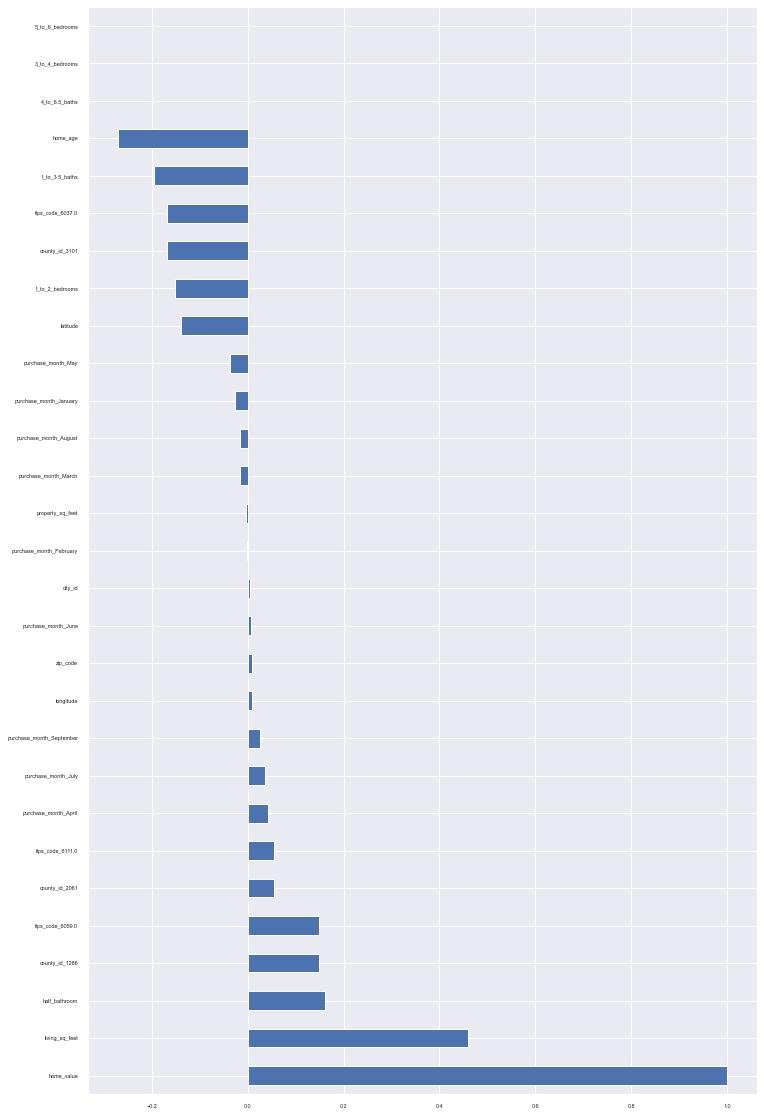

In [67]:
# plotting correlation amongst all data features

plt.figure(figsize=(12, 5))
train.corr()["home_value"].sort_values(ascending = False).plot.barh(figsize=(12, 20))
plt.show()

----
#### **``Hypothesis Testing:``**

<u>Taget and Categorical/discrete Feature:</u> T-test


1. 'bathroom_count'
2. 'bedroom_count'
3. 'fips_code'
4. 'county_id'
5. 'purchase_month

<u>Taget and Continuous Feature:</u> Pearson R/correlation

1. 'living_sq_feet'
2. 'latitude'
3. 'longitude'
4. 'property_sq_feet'
5. 'city_id'
6. 'zip_code'
7. 'year_built'
8. 'home_age'

In [68]:
X_train.select_dtypes(exclude = ["bool", "uint8"]).columns

Index(['living_sq_feet', 'latitude', 'longitude', 'property_sq_feet',
       'city_id', 'zip_code', 'home_age'],
      dtype='object')

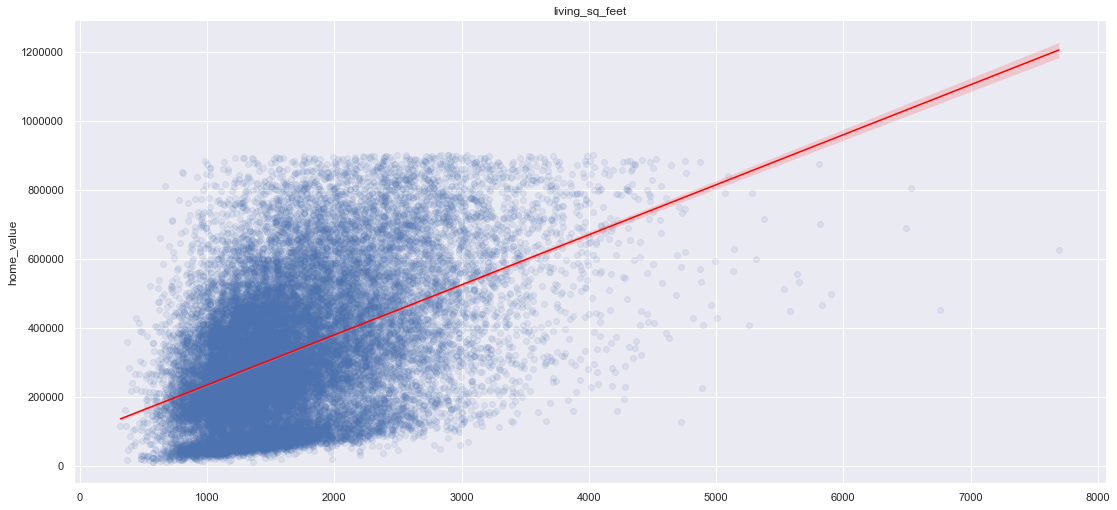

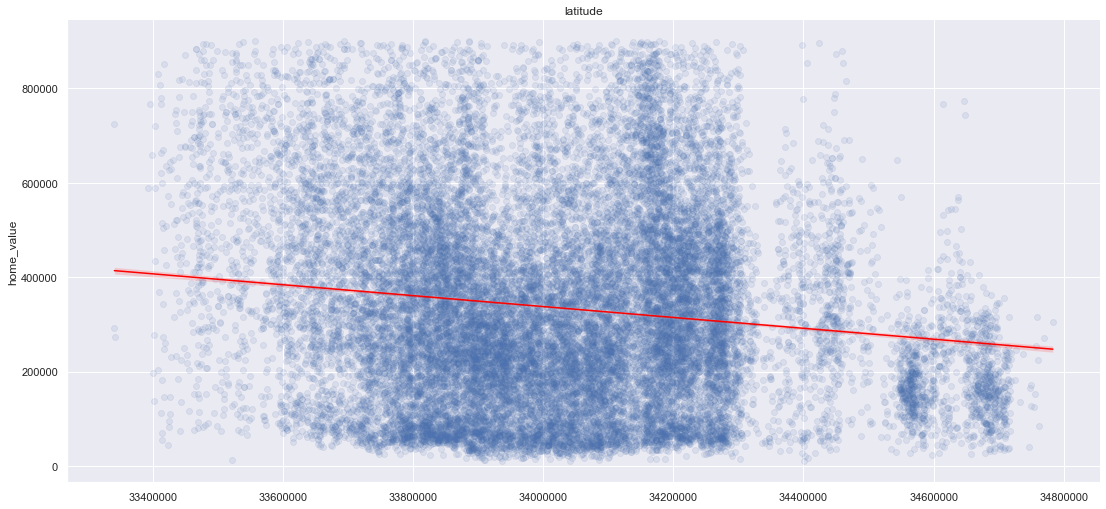

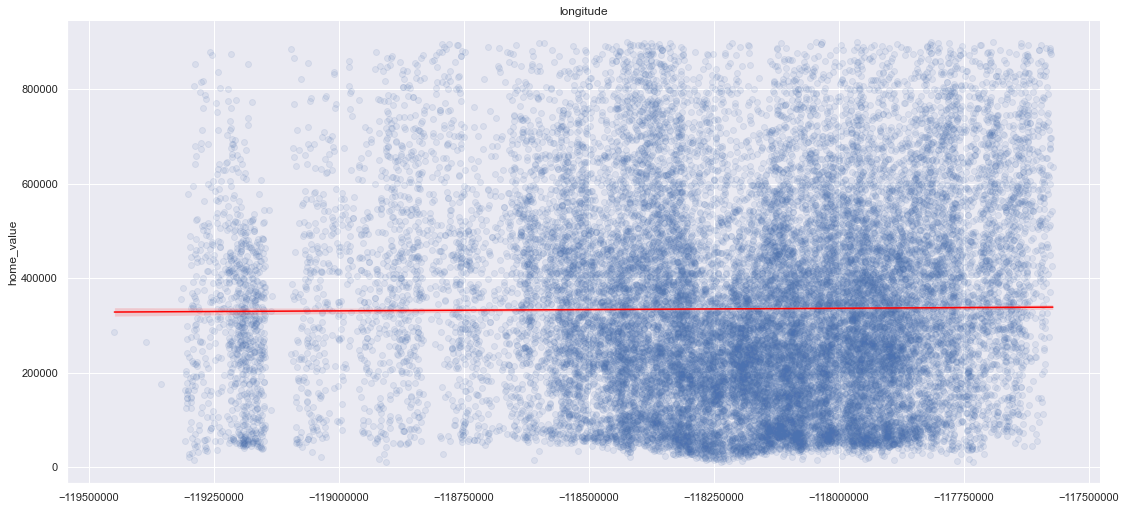

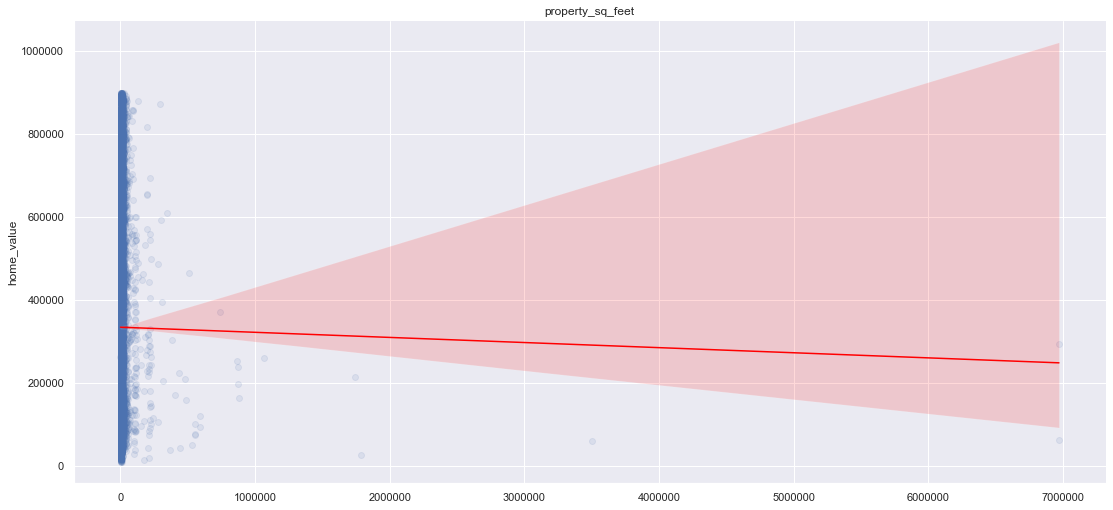

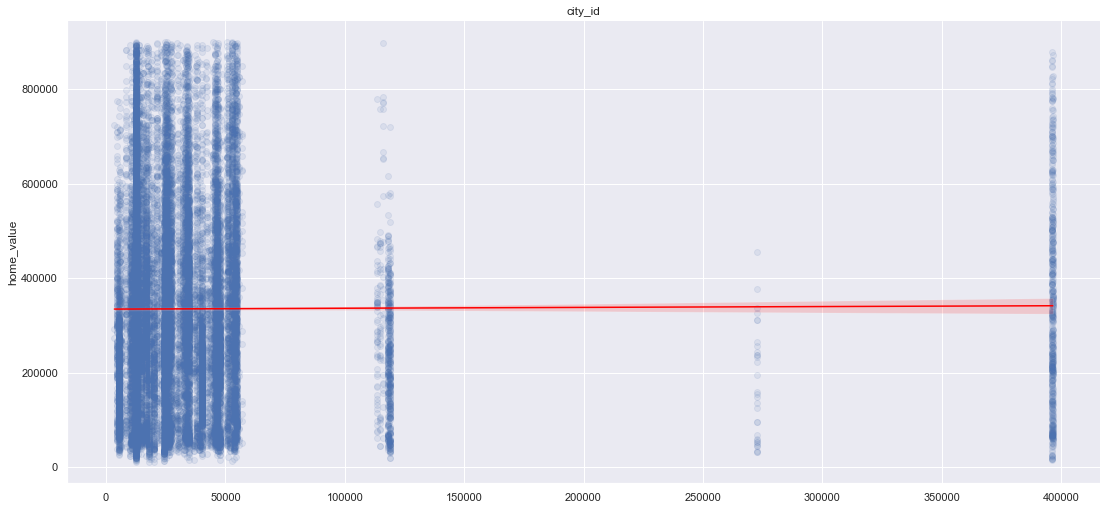

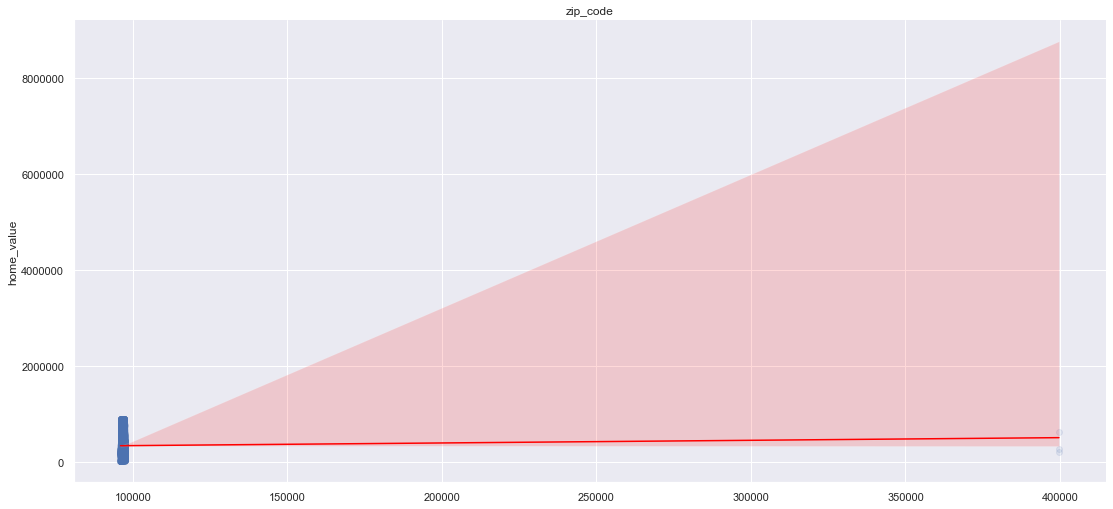

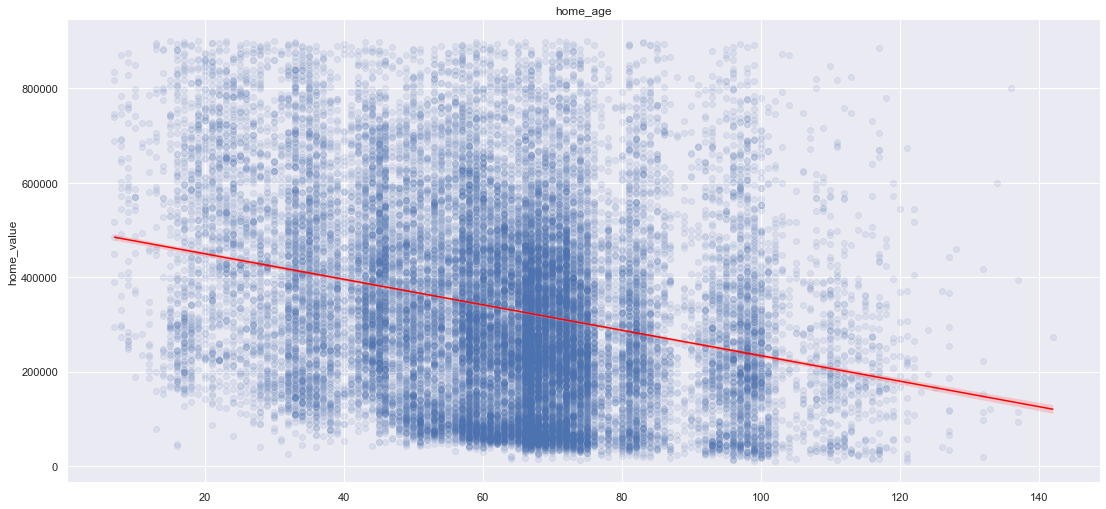

In [69]:
# sns visualizing all variables plotted against target  w/ line of best fit
# selecting initial variables to conduct a pair plot

pair_lst = X_train.select_dtypes(exclude = ["bool", "uint8"]).columns.tolist()

for col in pair_lst:
        plt.figure(figsize = (10, 4))
        sns.set(font_scale = 1)

        # plotting ea. feature against target variable with added alpha/transparency for aggregation areas
        ax = sns.regplot(train[col], \
        train["home_value"], \
        
        # adding superficial noise to independent variables to help visualize the individual plots
        scatter_kws = {'alpha': 1/10}, \
        line_kws={
            "color": "red", 'linewidth': 1.5})
        
        ax.figure.set_size_inches(18.5, 8.5)
        sns.despine()
        # removing scientific notations
        ax.ticklabel_format(style = "plain")
        
        # removing x_axis label
        ax.set_xlabel(None)

        plt.title(col)
        plt.show()

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27765 entries, 32589 to 27893
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   home_value                27765 non-null  float64
 1   living_sq_feet            27765 non-null  float64
 2   latitude                  27765 non-null  float64
 3   longitude                 27765 non-null  float64
 4   property_sq_feet          27765 non-null  float64
 5   city_id                   27765 non-null  int64  
 6   zip_code                  27765 non-null  int64  
 7   home_age                  27765 non-null  int64  
 8   half_bathroom             27765 non-null  bool   
 9   1_to_3.5_baths            27765 non-null  bool   
 10  4_to_6.5_baths            27765 non-null  bool   
 11  1_to_2_bedrooms           27765 non-null  bool   
 12  3_to_4_bedrooms           27765 non-null  bool   
 13  5_to_6_bedrooms           27765 non-null  bool   
 14  fi

In [71]:
cat_lst = train.select_dtypes(include = ["bool", "uint8"]).columns.tolist()
cont_lst = train.select_dtypes(exclude = ["object", "uint8", "bool"]).columns.tolist()

In [72]:
# looping through categorical samples (dummy variables) to determine statistical relationship to target variable
import scipy.stats as stats 

target_mean = round(y_train.mean(), 2)
alpha = 0.05

metrics = []
for col in cat_lst:
    sub_group = train[train[col] == 1].home_value
    t_score, p_value = stats.ttest_1samp(sub_group, target_mean)

    if p_value < alpha:
        output = {
            "discrete feature": col,
            "t_score": t_score,
            "p_value": p_value}
        
        metrics.append(output)

    else:
        print(f'Column: {col} not statistically significant.')
        print("--------------------------------------")

categorical_scores = pd.DataFrame(metrics)
categorical_scores.round(4)

Column: 4_to_6.5_baths not statistically significant.
--------------------------------------
Column: 3_to_4_bedrooms not statistically significant.
--------------------------------------
Column: 5_to_6_bedrooms not statistically significant.
--------------------------------------
Column: purchase_month_February not statistically significant.
--------------------------------------
Column: purchase_month_June not statistically significant.
--------------------------------------


,discrete feature,t_score,p_value
0,half_bathroom,24.2692,0.0000
1,1_to_3.5_baths,-5.8721,0.0000
2,1_to_2_bedrooms,-25.5077,0.0000
3,fips_code_6037.0,-16.7577,0.0000
4,fips_code_6059.0,20.5924,0.0000
5,fips_code_6111.0,8.6164,0.0000
6,county_id_1286,20.5924,0.0000
7,county_id_2061,8.6164,0.0000
8,county_id_3101,-16.7577,0.0000
9,purchase_month_April,6.6364,0.0000


In [73]:
# looping through continuous varibles to measure statistical realationship usign Pearson R method with target variable

target = train["home_value"]
alpha = 0.05

metrics = []

for col in cont_lst:
    r, p_value = stats.stats.pearsonr(train[col], target)

    if p_value < alpha:
        output = {
            "continuous feature": col,
            "correlation coeffficient": r,
            "p_value": p_value}
        
        metrics.append(output)

    else:
        print(f'Column: {col}')
        print(f'P_value: {round(p_value, 4)}')
        print('Not statistically significant.')
        print("--------------------------------------")

continuous_scores = pd.DataFrame(metrics)
continuous_scores.round(4)

Column: longitude
P_value: 0.1151
Not statistically significant.
--------------------------------------
Column: property_sq_feet
P_value: 0.498
Not statistically significant.
--------------------------------------
Column: city_id
P_value: 0.4247
Not statistically significant.
--------------------------------------
Column: zip_code
P_value: 0.153
Not statistically significant.
--------------------------------------


,continuous feature,correlation coeffficient,p_value
0,home_value,1.0000,0.0
1,living_sq_feet,0.4589,0.0
2,latitude,-0.1389,0.0
3,home_age,-0.2707,0.0


----
**``Statiscal Analysis/Conclusion Notes:``**

Given the low/no statistical significance found in the following features or values, i will elect to drop or disregard the following feature options. Looking ahead, I will want to further examing/explore why these feature or options are considered "statistically insignificant" when determining "home_value".

<u>``Continuous features``</u>
1. "city_id"
2. "property_sq_feet"
3. "longitude"
4. "zip_code"

<u>``Categorical/discrete values:``</u>
1. '4_to_6.5_baths'
2. '3_to_4_bedrooms'
3. '5_to_6_bedrooms'
4. 'purchase_month_February'
5. 'purchase_month_June'

In [74]:
# establishing new datasets for feature engineering and model pre-processing
# add function::::

X_train = X_train.drop(columns = [
    '4_to_6.5_baths',
    '3_to_4_bedrooms',
    '5_to_6_bedrooms',
    'purchase_month_February', 
    'purchase_month_June',
    "city_id", 
    "property_sq_feet",
    "longitude",
    "zip_code"])

X_validate = X_validate.drop(columns = [
    '4_to_6.5_baths',
    '3_to_4_bedrooms',
    '5_to_6_bedrooms',
    'purchase_month_February', 
    'purchase_month_June',
    "city_id", 
    "property_sq_feet",
    "longitude",
    "zip_code"])

# X_test = X_test.drop(columns = [
#     '4_to_6.5_baths',
#     '3_to_4_bedrooms',
#     '5_to_6_bedrooms',
#     'purchase_month_February', 
#     'purchase_month_June',
#     "city_id", 
#     "property_sq_feet",
#     "longitude",
#     "zip_code"])

In [75]:
# model feature cleaning function
def clean_for_features(df):
    df = df.drop(columns = [
        '4_to_6.5_baths',
        '3_to_4_bedrooms',
        '5_to_6_bedrooms',
        'purchase_month_February', 
        'purchase_month_June',
        "city_id", 
        "property_sq_feet",
        "longitude",
        "zip_code"])

    return df

----
**``Feature engineering for MVP Variables/features:``**

which x variables do i believe will hold the most significance in modeling?

* purchase month
* living sq feet
* home age
* number of bathrooms/bedrooms


<u>``Scaling continuous training (independent) variables/features:``</u>

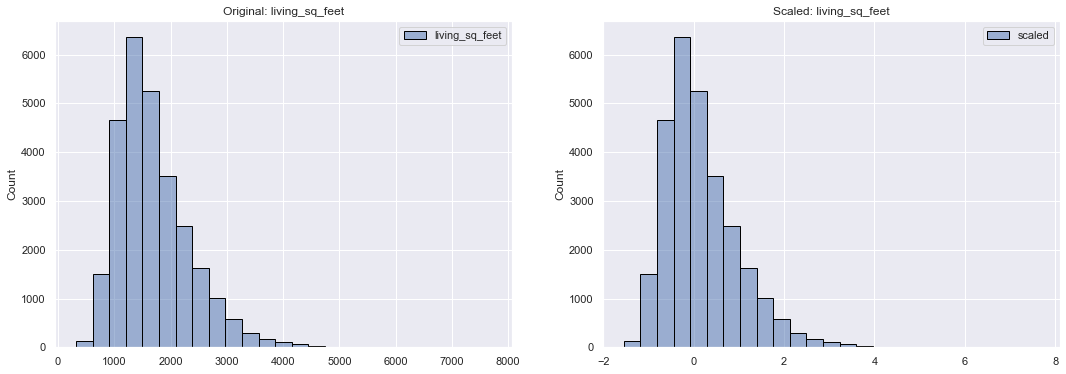

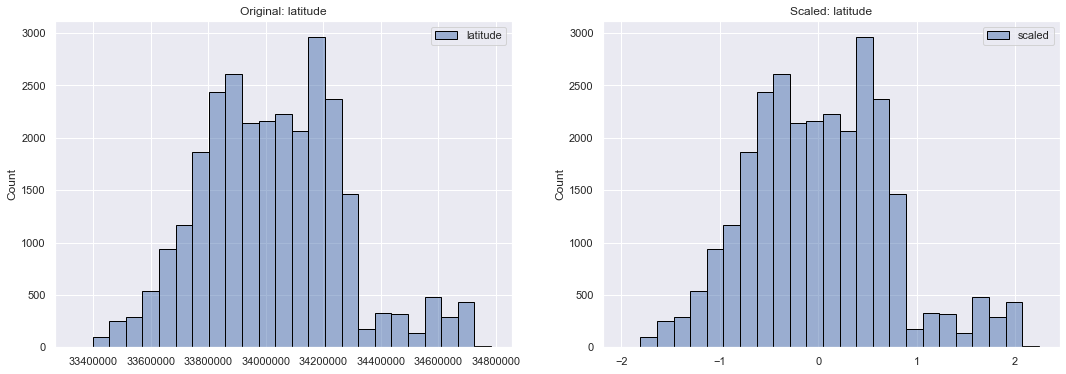

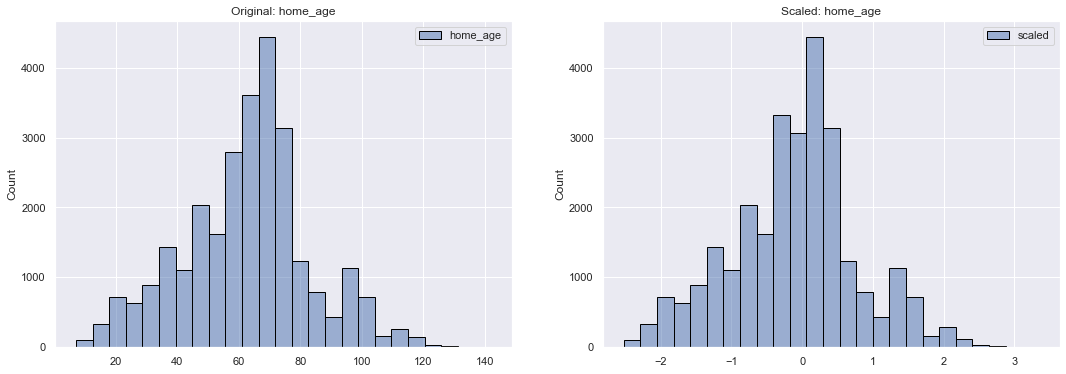

In [76]:
# Robust Scaler Plots

cont_lst = X_train.select_dtypes(exclude = ["object", "uint8", "bool"]).columns.tolist()

for col in cont_lst:
    scaler = RobustScaler()
    scaler.fit(X_train[[col]])

    x_scaled = scaler.transform(X_train[[col]])

    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    ax = sns.histplot(X_train[[col]], bins = 25, edgecolor = 'black', label = col)
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain") 
    plt.title(f'Original: {col}')
    plt.legend()

    plt.subplot(122)
    ax = sns.histplot(x_scaled, bins=25, edgecolor = 'black', label = "scaled")
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain") 
    plt.title(f'Scaled: {col}')
    plt.legend()

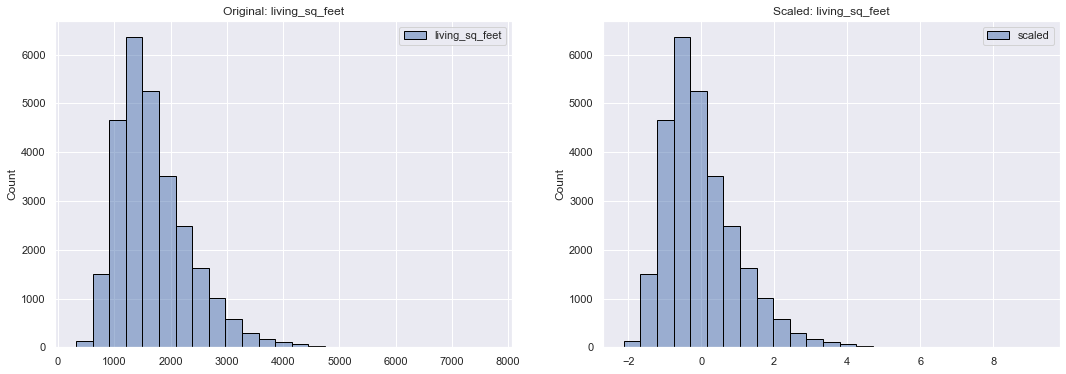

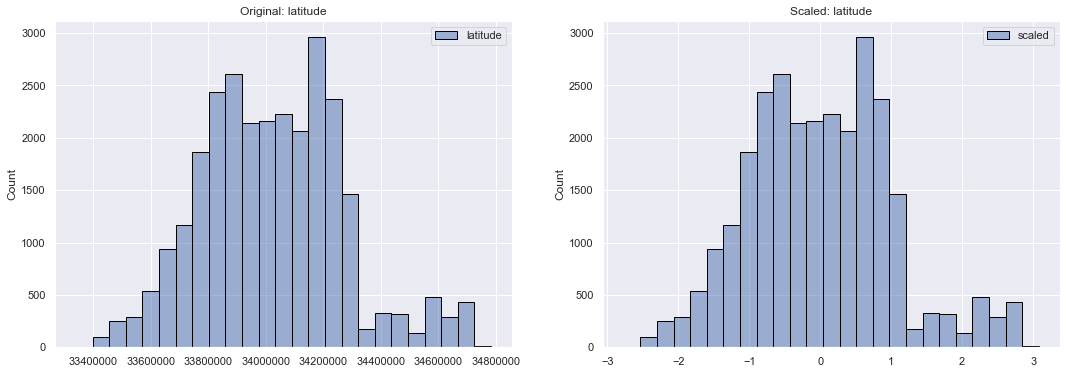

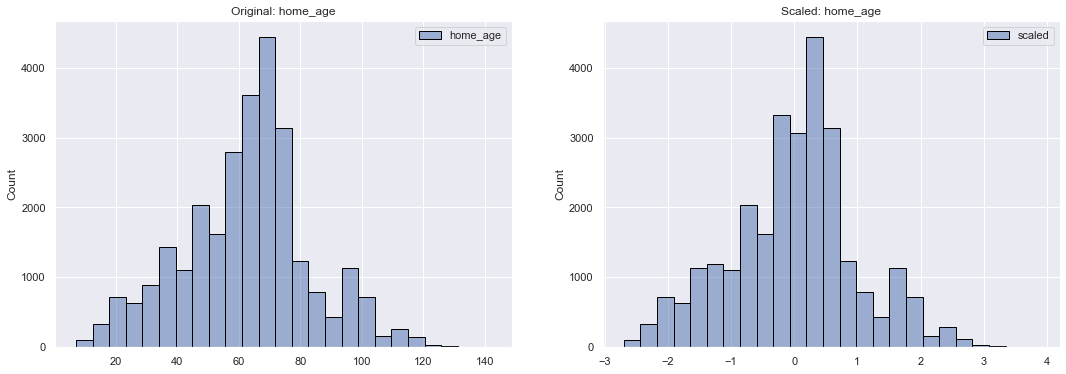

In [77]:
# Standard Scaler

for col in cont_lst:
    scaler = StandardScaler()
    scaler.fit(X_train[[col]])

    x_scaled = scaler.transform(X_train[[col]])

    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    ax = sns.histplot(X_train[[col]], bins = 25, edgecolor = 'black', label = col)
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain") 
    plt.title(f'Original: {col}')
    plt.legend()

    plt.subplot(122)
    ax = sns.histplot(x_scaled, bins=25, edgecolor = 'black', label = "scaled")
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain") 
    plt.title(f'Scaled: {col}')
    plt.legend()

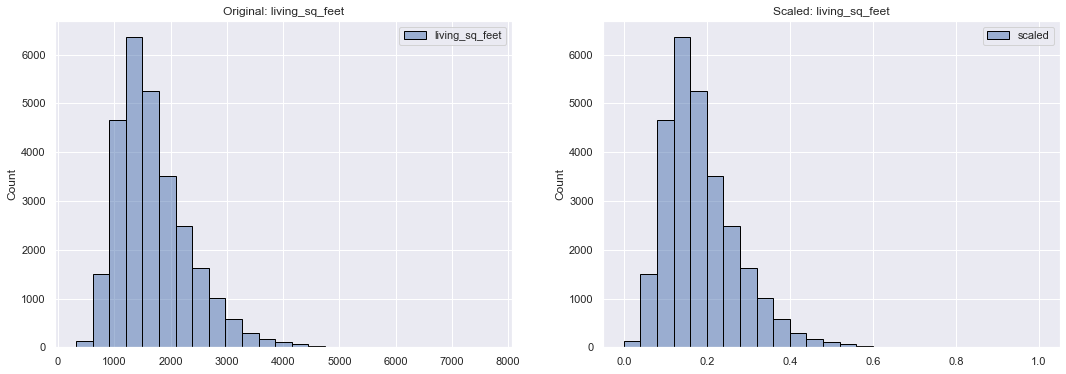

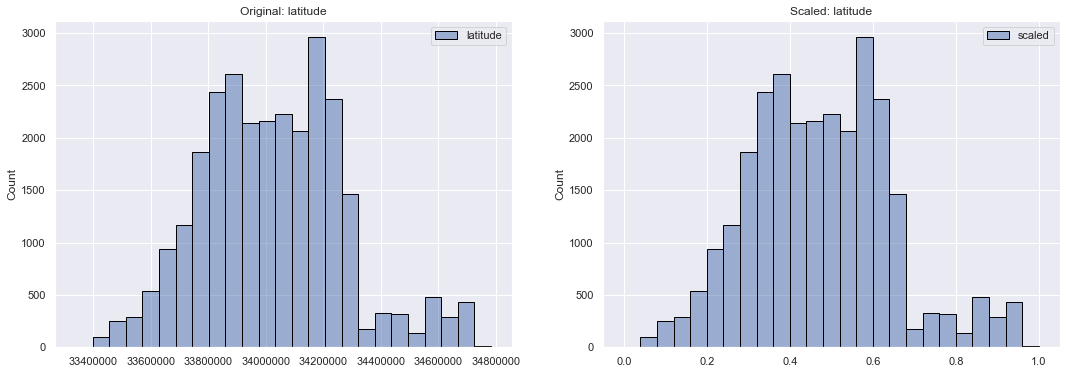

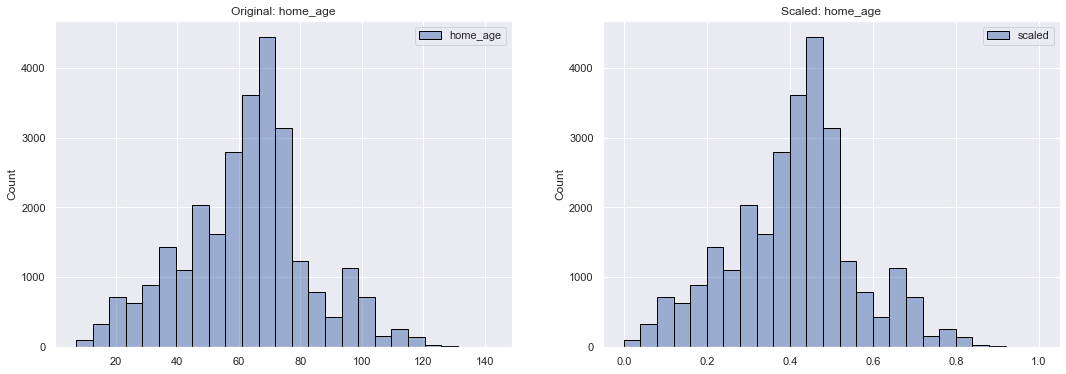

In [78]:
# MinMax Sccaler Plots

for col in cont_lst:

    scaler = MinMaxScaler()
    scaler.fit(X_train[[col]])

    x_scaled = scaler.transform(X_train[[col]])

    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    ax = sns.histplot(X_train[[col]], bins = 25, edgecolor = 'black', label = col)
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain") 
    plt.title(f'Original: {col}')
    plt.legend()

    plt.subplot(122)
    ax = sns.histplot(x_scaled, bins=25, edgecolor = 'black', label = "scaled")
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain")
    plt.title(f'Scaled: {col}')
    plt.legend()

In [79]:
# scaling continuous features/data with sklearn "MinMaxScaler"
# creating function to do this
# add function::::

def scaled_data(df, scaled_cols):
    # creating a copy of the original zillow/dataframe
    df_scaled = df.copy()

    scaler = RobustScaler()

    scaler.fit(df_scaled[scaled_cols])

    df_scaled[scaled_cols] = scaler.transform(df_scaled[scaled_cols])

    # returning newly created dataframe with scaled data
    return df_scaled

In [80]:
# creaing a new list for scaling (excludes target variable)
scaled_lst = X_train.columns.tolist()
scaled_lst

['living_sq_feet',
 'latitude',
 'home_age',
 'half_bathroom',
 '1_to_3.5_baths',
 '1_to_2_bedrooms',
 'fips_code_6037.0',
 'fips_code_6059.0',
 'fips_code_6111.0',
 'county_id_1286',
 'county_id_2061',
 'county_id_3101',
 'purchase_month_April',
 'purchase_month_August',
 'purchase_month_January',
 'purchase_month_July',
 'purchase_month_March',
 'purchase_month_May',
 'purchase_month_September']

In [81]:
# generating new X_train, and X_validate datasets w/scaled data
X_train = scaled_data(X_train, scaled_lst)
X_validate = scaled_data(X_validate, scaled_lst)

In [82]:
# passing kbest function on train dataset:

select_kbest(X_train, y_train, 10)

,0
0,living_sq_feet
1,latitude
2,home_age
3,half_bathroom
4,1_to_3.5_baths
5,1_to_2_bedrooms
6,fips_code_6037.0
7,fips_code_6059.0
8,county_id_1286
9,county_id_3101


In [83]:
# passing recursive function on train dataset:

recursive_feature_eng(X_train, y_train, 10).reset_index(drop=True)

,Feature,Ranking
0,living_sq_feet,1
1,county_id_2061,1
2,fips_code_6111.0,1
3,fips_code_6059.0,1
4,1_to_2_bedrooms,1
5,county_id_1286,1
6,half_bathroom,1
7,home_age,1
8,latitude,1
9,purchase_month_September,1


In [84]:
from sklearn.feature_selection import RFECV

# initiate, and fit
rfecv = RFECV(
    estimator = LinearRegression(),
    min_features_to_select = 5
)

rfecv = rfecv.fit(X_train, y_train)

In [85]:
feature_lst = X_train.columns[rfecv.support_].tolist()
feature_lst

['living_sq_feet',
 'latitude',
 'home_age',
 'half_bathroom',
 '1_to_3.5_baths',
 '1_to_2_bedrooms',
 'fips_code_6059.0',
 'fips_code_6111.0',
 'county_id_1286',
 'county_id_2061',
 'purchase_month_April',
 'purchase_month_August',
 'purchase_month_January',
 'purchase_month_July',
 'purchase_month_March',
 'purchase_month_May',
 'purchase_month_September']

In [86]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

lars = LassoLars()
lars_model = lars.fit(X_train, y_train)

glm = TweedieRegressor(alpha = 1, power = 0)
glm_model = glm.fit(X_train, y_train)

print("Training R-squared:", lr_model.score(X_train, y_train))
print("Training R-squared:", lars_model.score(X_train, y_train))
print("Training R-squared:", glm_model.score(X_train, y_train))

Training R-squared: 0.2442397473684509
Training R-squared: 0.24305495255890175
Training R-squared: 0.1658721348498302


In [87]:
#Create a looping statement to evaluate all models
from math import sqrt

models = [lr_model, lars_model, glm_model]

for model in models:

    train_model = model.predict(X_train)
    rmse_train = sqrt(mean_squared_error(y_train,
                                         train_model))
    
    validate_model = model.predict(X_validate)
    rmse_validate = sqrt(mean_squared_error(y_validate,
                                         validate_model))
    
    print('RMSE for {} model on the train dataset: {}.'.format(model, round(rmse_train, 2)))
    print('RMSE for {} model on the validate dataset: {}.'.format(model, round(rmse_validate, 2)))
    print()

RMSE for LinearRegression() model on the train dataset: 178296.33.
RMSE for LinearRegression() model on the validate dataset: 178914.2.

RMSE for LassoLars() model on the train dataset: 178436.03.
RMSE for LassoLars() model on the validate dataset: 179046.63.

RMSE for TweedieRegressor(alpha=1, power=0) model on the train dataset: 187312.47.
RMSE for TweedieRegressor(alpha=1, power=0) model on the validate dataset: 187368.63.



----
#### <u>**``Baseline Prediction & Evaluations:``**</u>

In [88]:
# creating the independent and dependent variables
X_var = pd.DataFrame(X_validate[feature_lst])
y_var = pd.DataFrame(y_validate)

In [89]:
model_df = pd.concat([X_var, y_var], axis = 1)
model_df.head()

,living_sq_feet,latitude,home_age,half_bathroom,1_to_3.5_baths,1_to_2_bedrooms,fips_code_6059.0,fips_code_6111.0,county_id_1286,county_id_2061,purchase_month_April,purchase_month_August,purchase_month_January,purchase_month_July,purchase_month_March,purchase_month_May,purchase_month_September,home_value
29338,0.350311,-0.679103,-0.086957,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,508180.0
18388,0.229814,-1.004348,-1.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,371363.0
55416,-0.254658,0.505117,0.304348,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,297814.0
52423,-0.561491,-1.157950,-0.608696,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,195380.0
22057,-0.544099,0.431858,0.043478,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,371920.0


In [90]:
# creating a mean baseline prediction
baseline_mean_predictions = round(y_validate.mean(), 2)
baseline_mean_predictions

334921.45

In [91]:
# adding baseline to model_df
model_df["baseline_mean_predictions"] = baseline_mean_predictions
model_df.head()

,living_sq_feet,latitude,home_age,half_bathroom,1_to_3.5_baths,1_to_2_bedrooms,fips_code_6059.0,fips_code_6111.0,county_id_1286,county_id_2061,purchase_month_April,purchase_month_August,purchase_month_January,purchase_month_July,purchase_month_March,purchase_month_May,purchase_month_September,home_value,baseline_mean_predictions
29338,0.350311,-0.679103,-0.086957,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,508180.0,334921.45
18388,0.229814,-1.004348,-1.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,371363.0,334921.45
55416,-0.254658,0.505117,0.304348,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,297814.0,334921.45
52423,-0.561491,-1.157950,-0.608696,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,195380.0,334921.45
22057,-0.544099,0.431858,0.043478,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,371920.0,334921.45


In [92]:
# generating validate model predictions and assigning to dataframe
lr_predictions = lr_model.predict(X_validate)
model_df["linear_predictions"] = lr_predictions.round(2)

lars_predictions = lars_model.predict(X_validate)
model_df["lars_predictions"] = lars_predictions.round(2)

glm_predictions = lars_model.predict(X_validate)
model_df["glm_predictions"] = glm_predictions.round(2)

In [93]:
# checking the df
model_df.head()

,living_sq_feet,latitude,home_age,half_bathroom,1_to_3.5_baths,1_to_2_bedrooms,fips_code_6059.0,fips_code_6111.0,county_id_1286,county_id_2061,...,purchase_month_January,purchase_month_July,purchase_month_March,purchase_month_May,purchase_month_September,home_value,baseline_mean_predictions,linear_predictions,lars_predictions,glm_predictions
29338,0.350311,-0.679103,-0.086957,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,508180.0,334921.45,355234.46,365429.60,365429.60
18388,0.229814,-1.004348,-1.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,371363.0,334921.45,435794.65,424557.89,424557.89
55416,-0.254658,0.505117,0.304348,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,297814.0,334921.45,300017.95,289994.14,289994.14
52423,-0.561491,-1.157950,-0.608696,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,195380.0,334921.45,292262.55,298325.44,298325.44
22057,-0.544099,0.431858,0.043478,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,371920.0,334921.45,253855.12,251507.98,251507.98


In [94]:
def regression_errors(y, y_hat):
    # importing math.sqrt module for calculations
    from math import sqrt
    
    # generating model residuals and residuals squared
    df = y - y_hat
    df["residual^2"] = df.round(2) ** 2

    # generating sum of squared error
    SSE = sum(df["residual^2"])

    # generating explained sum of squares
    ESS = sum((y_hat - y.mean()) ** 2)

    # generating total sum of squares error
    TSS = ESS + SSE

    # generating mean squared error
    MSE = SSE/len(y)

    # generating root mean squared error
    RMSE = sqrt(MSE)

    return SSE, ESS, TSS, MSE, RMSE

In [95]:
# getting error reports for baseline predictions

SSE, ESS, TSS, MSE, RMSE = regression_errors(model_df["home_value"], model_df["baseline_mean_predictions"])

print('Baseline SSE = {:.1f}'.format(SSE))
print('Baseline ESS = {:.1f}'.format(ESS))
print('Baseline TSS = {:.1f}'.format(TSS))
print('Baseline MSE = {:.1f}'.format(MSE))
print('Baseline RMSE = {:.1f}'.format(RMSE))

Baseline SSE = 498784666610531.9
Baseline ESS = 0.3
Baseline TSS = 498784666610532.2
Baseline MSE = 41914677866.4
Baseline RMSE = 204730.7


In [96]:
# getting error reports for linear model predictions

SSE, ESS, TSS, MSE, RMSE = regression_errors(model_df["home_value"], model_df["linear_predictions"])

print('Model SSE = {:.1f}'.format(SSE))
print('Model ESS = {:.1f}'.format(ESS))
print('Model TSS = {:.1f}'.format(TSS))
print('Model MSE = {:.1f}'.format(MSE))
print('Model RMSE = {:.1f}'.format(RMSE))

Model SSE = 380922444312165.2
Model ESS = 121233107350265.9
Model TSS = 502155551662431.1
Model MSE = 32010289438.0
Model RMSE = 178914.2


In [97]:
def get_error_report(y, y_hat):
    # importing math.sqrt module for calculations
    from math import sqrt
    
    # generating model residuals and residuals squared
    df = y - y_hat
    df["residual^2"] = df.round(2) ** 2

    # generating sum of squared error
    SSE = sum(df["residual^2"])

    # generating explained sum of squares
    ESS = sum((y_hat - y.mean()) ** 2)

    # generating total sum of squares error
    TSS = ESS + SSE

    # generating mean squared error
    MSE = SSE/len(y)

    # generating root mean squared error
    RMSE = sqrt(MSE)

    print(f'{y_hat.name} SSE: {SSE}')
    print(f'{y_hat.name} ESS: {ESS}')
    print(f'{y_hat.name} TSS: {TSS}')
    print(f'{y_hat.name} MSE: {MSE}')
    print(f'{y_hat.name} RMSE: {RMSE}')

    return SSE, ESS, TSS, MSE, RMSE

In [98]:
SSE, ESS, TSS, MSE, RMSE = get_error_report(model_df["home_value"], model_df["glm_predictions"])

glm_predictions SSE: 381486588875782.3
glm_predictions ESS: 114322513495073.8
glm_predictions TSS: 495809102370856.1
glm_predictions MSE: 32057696544.183388
glm_predictions RMSE: 179046.6323173474


In [99]:
# final error report df

final_report = {
'Models': ['Baseline Predictions', 'Linear Regression Predictions', 'Tweedie Regressor Predictions'],
'Explained Sum of Squares (ESS)': [0.3, 121233107350265.9, 114322513495073.8],
'Mean Sum Error (MSE)': [41914677866.4, 32010289438.0, 32057696544.18],
'Root Mean Squared Error (RMSE)': [204730.7, 178914.2, 179046.63]
}

pd.set_option('display.float_format', lambda x: '%.2f' % x)
final_report = pd.DataFrame(final_report)
final_report.head()

,Models,Explained Sum of Squares (ESS),Mean Sum Error (MSE),Root Mean Squared Error (RMSE)
0,Baseline Predictions,0.30,41914677866.40,204730.70
1,Linear Regression Predictions,121233107350265.91,32010289438.00,178914.20
2,Tweedie Regressor Predictions,114322513495073.80,32057696544.18,179046.63


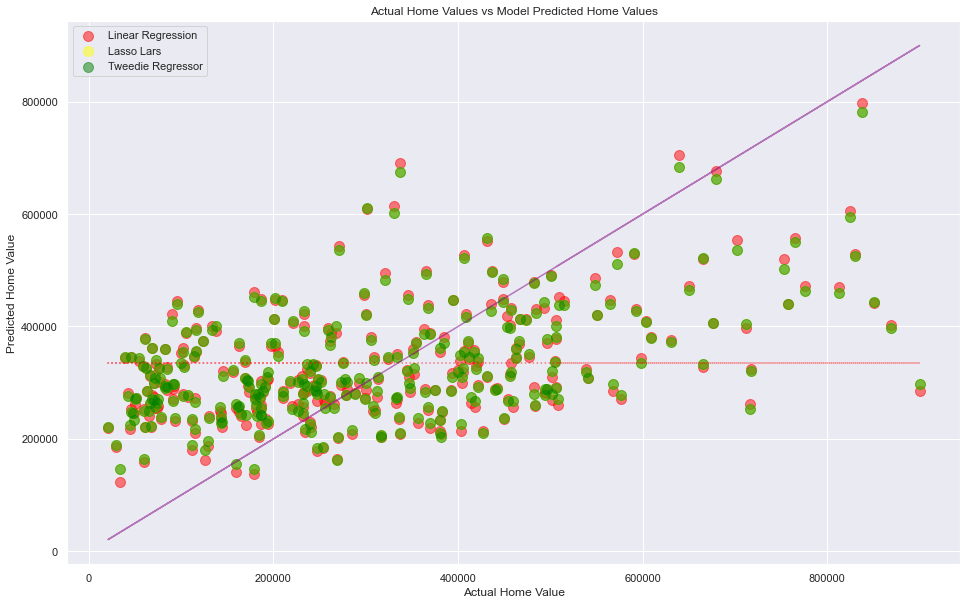

In [100]:
# plotting actual home values, baseline_mean_predictions predictions, and model predictions
# add function:::

plt.figure(figsize = (16, 10))

# plotting baseline prediction line of best fit
plt.plot(model_df['home_value'].sample(300, 
        random_state = 123), 
        model_df['baseline_mean_predictions'].sample(300, random_state = 123), 
        alpha=0.5,
        color='red', 
        ls = ':', 
        label='_nolegend_')

# plotting home value line of best fit
plt.plot(model_df['home_value'].sample(300, random_state = 123), 
        model_df['home_value'].sample(300, random_state = 123), 
        alpha=0.5,
        color='purple', 
        label='_nolegend_')

# linear model plot
plt.scatter(model_df['home_value'].sample(300, random_state = 123), 
            model_df['linear_predictions'].sample(300, random_state = 123), 
            alpha=0.5,
            color='red', 
            s=100,
            label='Linear Regression')

# lasso lars plot
plt.scatter(model_df['home_value'].sample(300, random_state = 123), 
            model_df['lars_predictions'].sample(300, random_state = 123), 
            alpha=0.5,
            color='yellow', 
            s=100, 
            label='Lasso Lars')

# tweedie/glm plot
plt.scatter(model_df['home_value'].sample(300, random_state = 123), 
            model_df['glm_predictions'].sample(300, random_state = 123), 
            alpha=0.5,
            color='green', 
            s=100, 
            label='Tweedie Regressor')


plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel('Predicted Home Value')
plt.title('Actual Home Values vs Model Predicted Home Values')

plt.show()

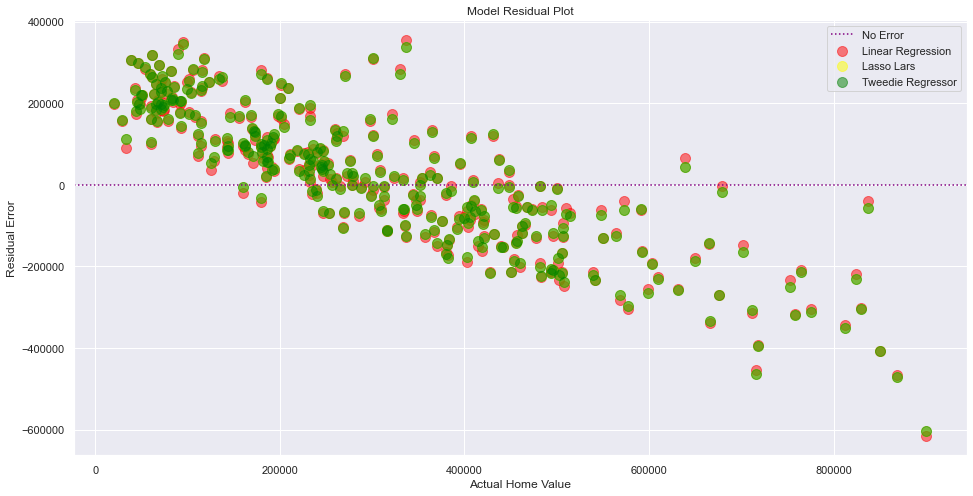

In [101]:
# Model Residual (error) Plot

plt.figure(figsize=(16,8))
plt.axhline(label='No Error', 
            color = 'purple',
            ls = ':')

# plotting linear model
plt.scatter(model_df['home_value'].sample(300, random_state = 123), 
            model_df['linear_predictions'].sample(300, random_state = 123) - model_df['home_value'].sample(300, random_state = 123), 
            alpha=0.5,
            color='red', 
            s=100, 
            label='Linear Regression')

# plotting lasso lars model
plt.scatter(model_df['home_value'].sample(300, random_state = 123), 
            model_df['lars_predictions'].sample(300, random_state = 123) - model_df['home_value'].sample(300, random_state = 123), 
            alpha=0.5,
            color='yellow', 
            s=100, 
            label='Lasso Lars')

# plotting tweedie model
plt.scatter(model_df['home_value'].sample(300, random_state = 123), 
            model_df['glm_predictions'].sample(300, random_state = 123) - model_df['home_value'].sample(300, random_state = 123), 
            alpha=0.5,
            color='green', 
            s=100, 
            label='Tweedie Regressor')

plt.legend()
plt.xlabel('Actual Home Value')
plt.ylabel('Residual Error')
plt.title('Model Residual Plot')

plt.show()

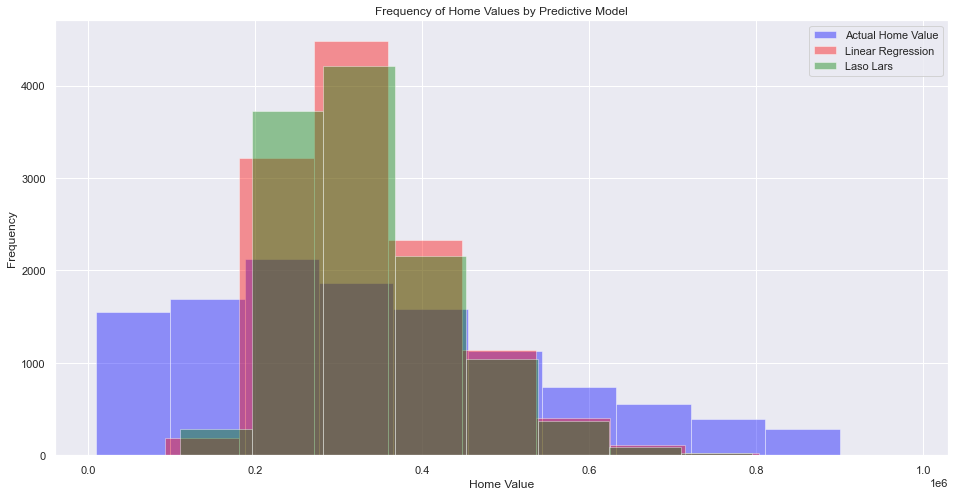

In [102]:
# Distribution of my model predictions (linear & tweedie)
# add function:::

plt.figure(figsize = (16, 8))
sns.set(style = "darkgrid")

plt.hist(model_df['home_value'], color='blue', alpha=0.4, label='Actual Home Value')
plt.hist(model_df['linear_predictions'], color='red', alpha=0.4, label='Linear Regression')
plt.hist(model_df['lars_predictions'], color='green', alpha=0.4, label='Laso Lars')


plt.xlabel('Home Value')
plt.ylabel('Frequency')
plt.title('Frequency of Home Values by Predictive Model')
plt.legend()

plt.show()

In [103]:
# final model predictions and score on Test Dataset

test_df = pd.DataFrame(y_test)
print(test_df.shape )
test_df.head() # checks out!

(9917, 1)


,home_value
52190,135438.00
12407,306324.00
42714,411754.00
30367,54462.00
23282,171907.00


In [104]:
# scaling X_test data using created scaling function

X_test = scaled_data(X_test, scaled_lst)

In [105]:
# cleaning X_test dataset for model features

X_test = clean_for_features(X_test)
X_test.shape # checks out!

(9917, 19)

In [106]:
test_df["model_predictions"] = lr_model.predict(X_test)
test_df.head()

,home_value,model_predictions
52190,135438.00,441395.25
12407,306324.00,318993.49
42714,411754.00,367874.13
30367,54462.00,246687.00
23282,171907.00,191700.03


In [107]:

rmse_test = sqrt(mean_squared_error(test_df['home_value'], test_df['model_predictions']))
print(f'RMSE for OLS model on the test dataset: {round(rmse_test, 2)}')

RMSE for OLS model on the test dataset: 177111.14


In [108]:
final_rmse = pd.DataFrame({
    "Test": ["Baseline", "Train", "Validate", "Final"],
    "RMSE": [204730.70,178296.33,178914.20,177111.14],
    "Relative Diff.": [0, .15, 0, .01]})

In [109]:
final_rmse

,Test,RMSE,Relative Diff.
0,Baseline,204730.70,0.00
1,Train,178296.33,0.15
2,Validate,178914.20,0.00
3,Final,177111.14,0.01
